# **Importing library&function**






In [76]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, mean_squared_error, auc
from IPython.core.display import display, HTML
import numpy as np
import time
import os
from google.colab import drive
import itertools

!pip install split_folders
import splitfolders

!pip install scikit-learn

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
!ls /content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/
import splitfolders
import os
loc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/"
# csvloc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Result/"

gray_cataract  gray_diabetic_retinopathy  gray_glaucoma  gray_normal


In [79]:
import os
splitfolders.ratio(loc,output = "outputgrayscale",ratio = (0.90,0.05,0.05))
for dirpath,dirname,filename in os.walk("./outputgrayscale"):
  print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")

Copying files: 4238 files [00:09, 461.17 files/s]

There are 3 directories and 0 images in './outputgrayscale'.
There are 4 directories and 0 images in './outputgrayscale/test'.
There are 0 directories and 55 images in './outputgrayscale/test/gray_normal'.
There are 0 directories and 56 images in './outputgrayscale/test/gray_diabetic_retinopathy'.
There are 0 directories and 52 images in './outputgrayscale/test/gray_glaucoma'.
There are 0 directories and 53 images in './outputgrayscale/test/gray_cataract'.
There are 4 directories and 0 images in './outputgrayscale/train'.
There are 0 directories and 966 images in './outputgrayscale/train/gray_normal'.
There are 0 directories and 989 images in './outputgrayscale/train/gray_diabetic_retinopathy'.
There are 0 directories and 915 images in './outputgrayscale/train/gray_glaucoma'.
There are 0 directories and 943 images in './outputgrayscale/train/gray_cataract'.
There are 4 directories and 0 images in './outputgrayscale/val'.
There are 0 directories and 53 images in './outputgrayscale/val/g

In [80]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6,
                                             min_delta = 0.0001)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2,
                                                patience = 4,min_lr = 1e-7)

In [81]:
def predict_labels(model, X_test):
    return model.predict(X_test)

def display_classification_report(y_test, y_pred):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

def calculate_specificity(y_test, y_pred):
    # tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # specificity = tn / (tn + fp)
    # print(f"Specificity: {specificity}")
    cm = confusion_matrix(y_test, y_pred)
    specificity = []
    for i in range(cm.shape[0]):
      spec = cm[i, i] / (np.sum(cm[i, :]) - cm[i, i] + np.sum(cm[:, :]) - np.sum(cm[i, :]))
      specificity.append(spec)
    print(f"Specificity: {specificity}")

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize
    n_classes = cm.shape[0]  # find the number of classes

    specificity = []  # To store specificity values for each class

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels
    )

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        specificity_val = (cm.sum() - cm[i].sum() - cm[:, j].sum() + cm[i, j]) / (
            cm.sum() - cm[:, j].sum()
        )
        specificity.append(specificity_val)

        if norm:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%,\n {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%, Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )
        else:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ( {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} (Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )

    if savefig:
        fig.savefig("confusion_matrix.png")

    return specificity

def calculate_mse(y_test, y_probs, n_classes):
  y_true_onehot = tf.keras.utils.to_categorical(y_test, n_classes)
  mse = mean_squared_error(y_true_onehot, y_probs)
  print(f"Mean Squared Error: : {mse}")
  return y_true_onehot

def calculate_roc_auc_score(y_test, y_probs):
  auc_roc = roc_auc_score(y_test, y_probs, multi_class='ovr', average=None)
  average_auc_roc = np.mean(auc_roc)
  print(f"The average AUC-ROC is {average_auc_roc}")

# **Batch size: 16**

In [7]:
epoch = 20
batchsize = 16

In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3813 files belonging to 4 classes.
Found 216 files belonging to 4 classes.
Found 209 files belonging to 4 classes.


# **EfficientNetV2B3 Model**

In [9]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


52606240/52606240 [==============================] - 3s 0us/step


In [10]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 32)                49184     
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
 activation (Activation)     (None, 4)                 0     

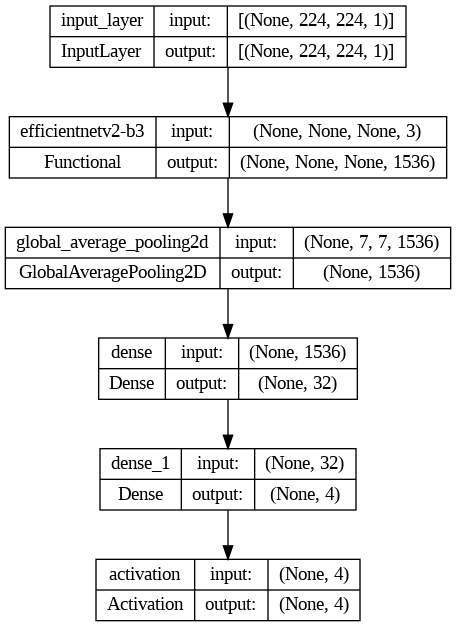

In [11]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [12]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [13]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
239/239 [==============================] - 35s 63ms/step - loss: 0.6066 - accuracy: 0.7590 - val_loss: 0.4444 - val_accuracy: 0.8278 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 12s 49ms/step - loss: 0.4501 - accuracy: 0.8259 - val_loss: 0.3626 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 12s 49ms/step - loss: 0.3872 - accuracy: 0.8529 - val_loss: 0.3296 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 12s 49ms/step - loss: 0.3681 - accuracy: 0.8615 - val_loss: 0.3007 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 12s 49ms/step - loss: 0.3356 - accuracy: 0.8728 - val_loss: 0.3133 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 12s 50ms/step - loss: 0.3296 - accuracy: 0.8710 - val_loss: 0.2740 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 7/20
239/239 [==============================] - 12s 

EfficientNetV2B3 Evaluation

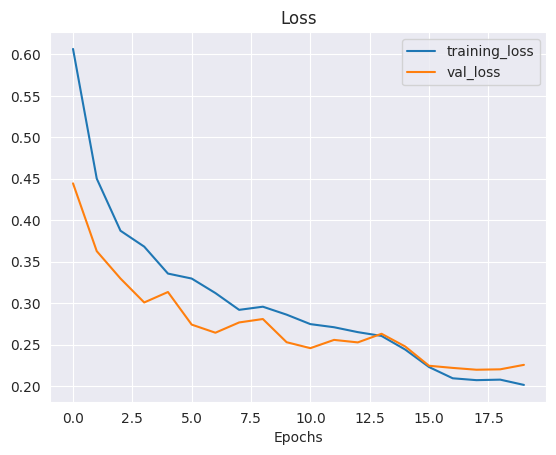

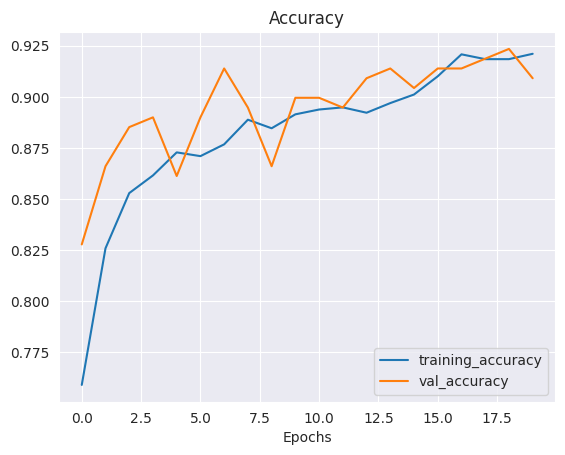

In [14]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 43ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        53
           1       0.98      1.00      0.99        56
           2       0.91      0.79      0.85        52
           3       0.89      0.93      0.91        55

    accuracy                           0.92       216
   macro avg       0.92      0.91      0.91       216
weighted avg       0.92      0.92      0.92       216

Specificity: [0.30120481927710846, 0.35, 0.2342857142857143, 0.3090909090909091]
Mean Squared Error: : 0.10820864886045456
The average AUC-ROC is 0.991194093929135


[0.9811320754716981,
 0.6666666666666666,
 0.7017543859649122,
 0.6729559748427673,
 0.6477987421383647,
 1.0,
 0.672514619883041,
 0.6477987421383647,
 0.7044025157232704,
 0.6792452830188679,
 0.935672514619883,
 0.7044025157232704,
 0.6666666666666666,
 0.6540880503144654,
 0.6900584795321637,
 0.9748427672955975]

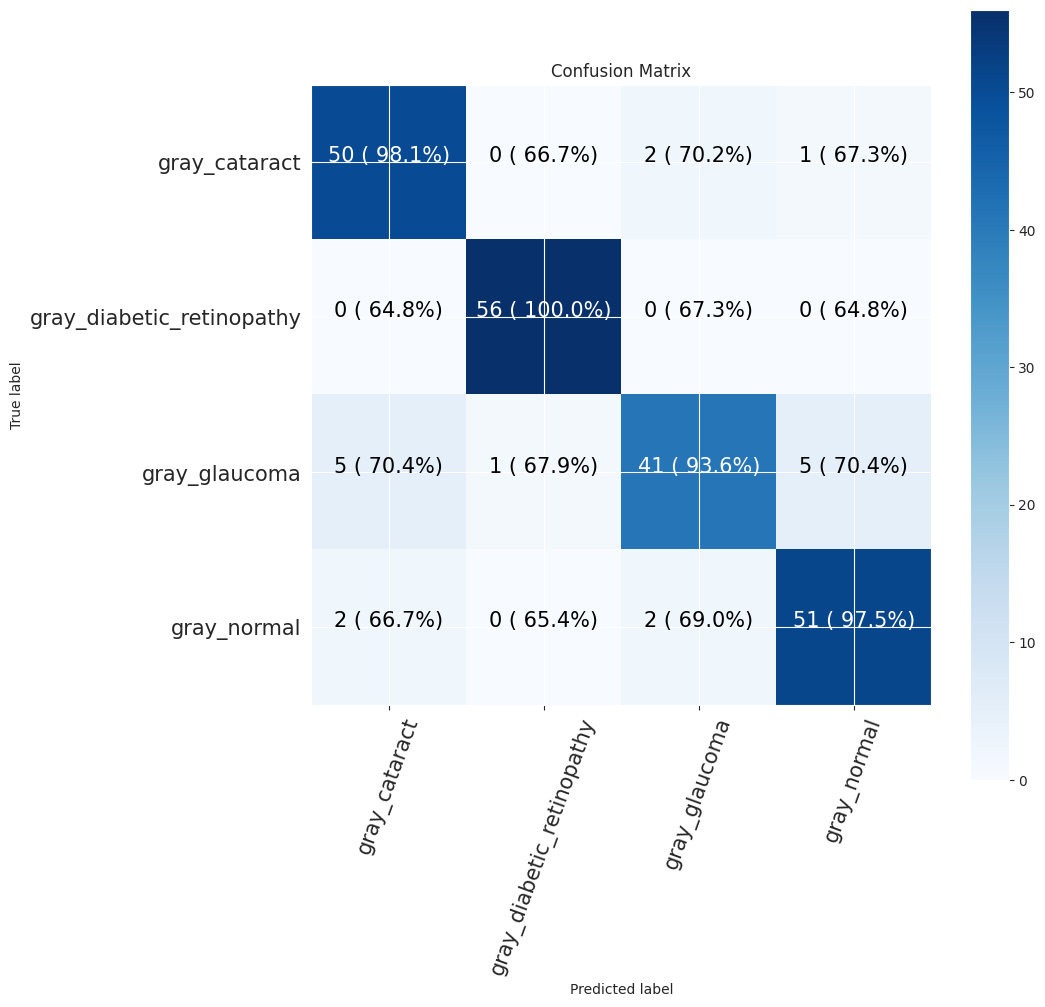

In [15]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


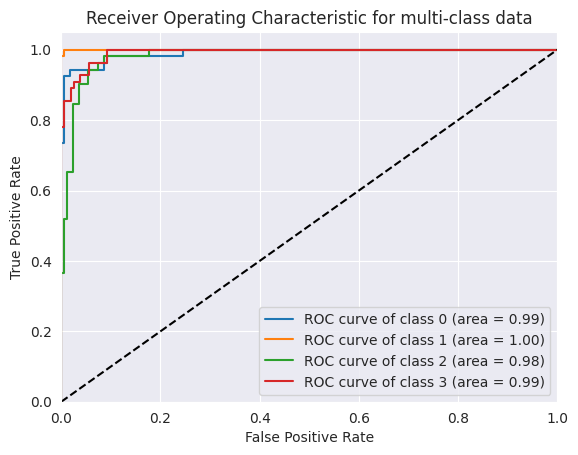

In [16]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [17]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

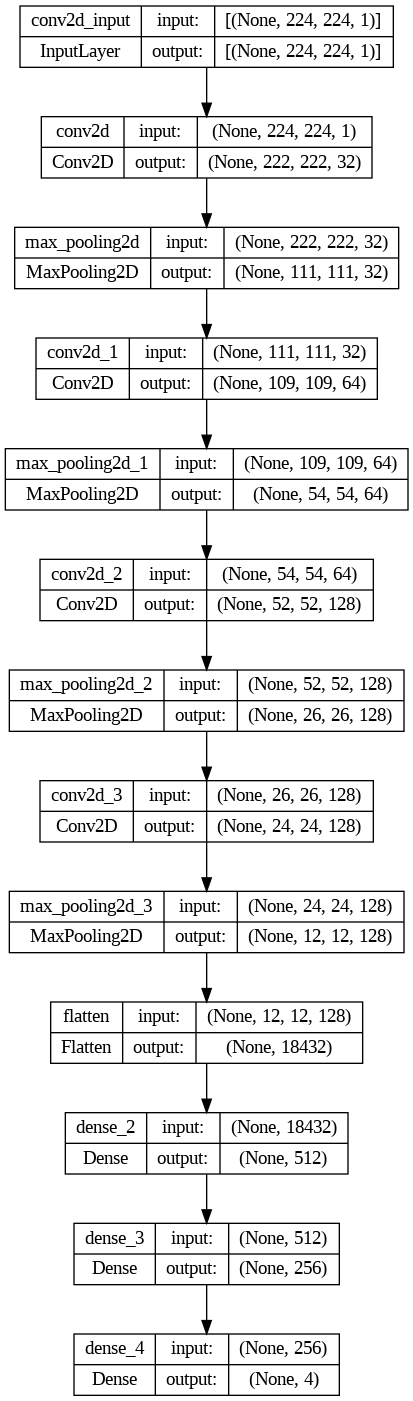

In [18]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [19]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [20]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
239/239 [==============================] - 9s 22ms/step - loss: 1.9692 - accuracy: 0.5744 - val_loss: 0.6974 - val_accuracy: 0.6507 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 5s 20ms/step - loss: 0.6172 - accuracy: 0.7212 - val_loss: 0.5604 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 5s 20ms/step - loss: 0.4784 - accuracy: 0.7954 - val_loss: 0.4238 - val_accuracy: 0.8230 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 5s 20ms/step - loss: 0.4529 - accuracy: 0.8177 - val_loss: 0.3722 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 5s 20ms/step - loss: 0.7521 - accuracy: 0.6942 - val_loss: 0.6571 - val_accuracy: 0.7129 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 5s 20ms/step - loss: 0.6573 - accuracy: 0.7105 - val_loss: 0.5972 - val_accuracy: 0.7177 - lr: 0.0010
Epoch 7/20
239/239 [==============================] - 5s 20ms/st

CNN Evaluation

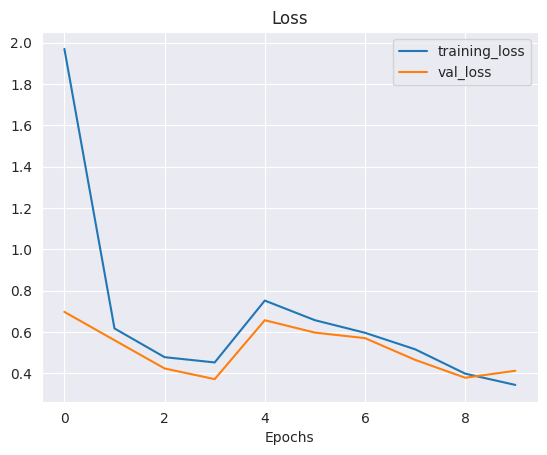

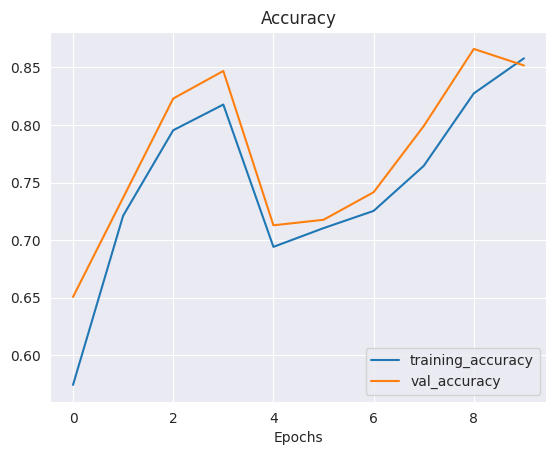

In [21]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 7ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.62      0.73        53
           1       0.98      1.00      0.99        56
           2       0.70      0.71      0.70        52
           3       0.75      0.95      0.84        55

    accuracy                           0.82       216
   macro avg       0.83      0.82      0.82       216
weighted avg       0.83      0.82      0.82       216

Specificity: [0.18032786885245902, 0.35, 0.20670391061452514, 0.3170731707317073]
Mean Squared Error: : 0.12255769222974777
The average AUC-ROC is 0.9590155936157184


[0.888268156424581,
 0.6729559748427673,
 0.7607361963190185,
 0.673469387755102,
 0.6871508379888268,
 1.0,
 0.656441717791411,
 0.6190476190476191,
 0.7262569832402235,
 0.6729559748427673,
 0.9079754601226994,
 0.7278911564625851,
 0.6983240223463687,
 0.6540880503144654,
 0.6748466257668712,
 0.9795918367346939]

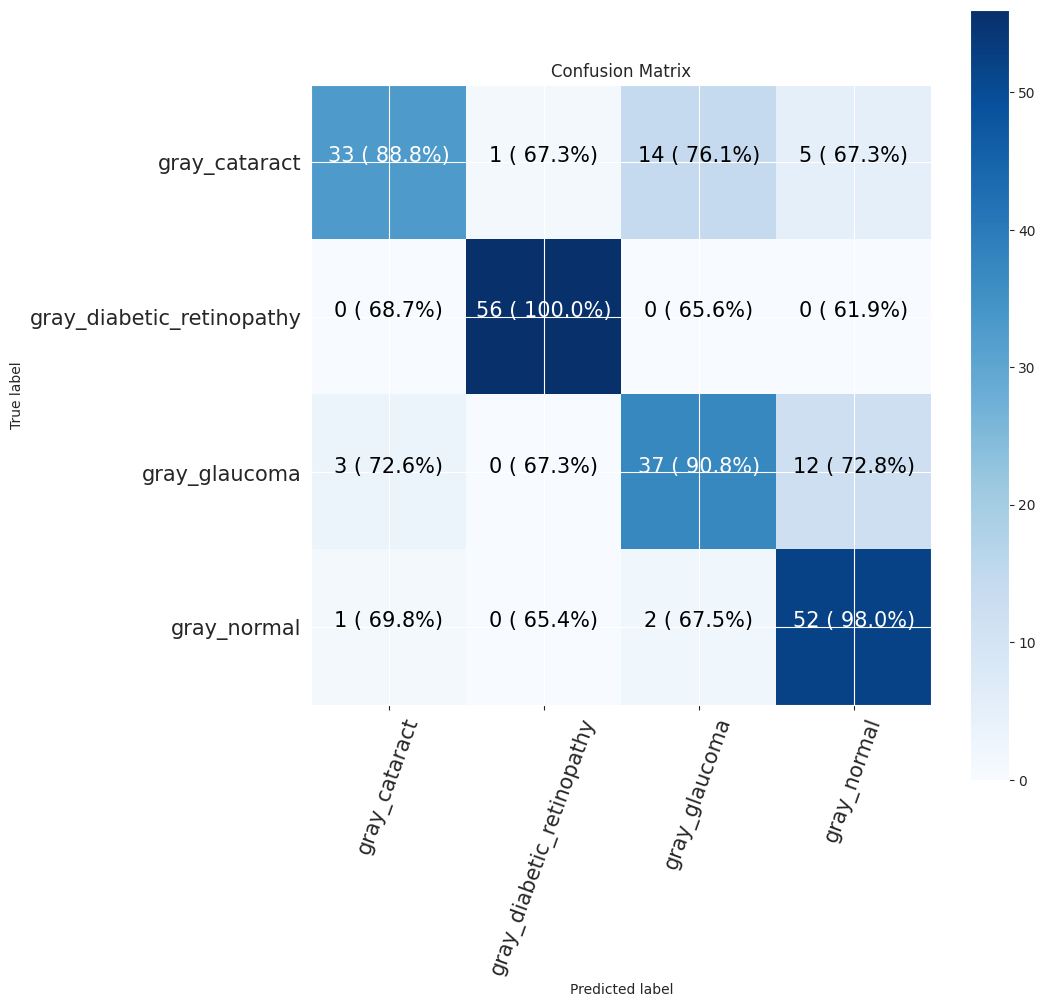

In [22]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


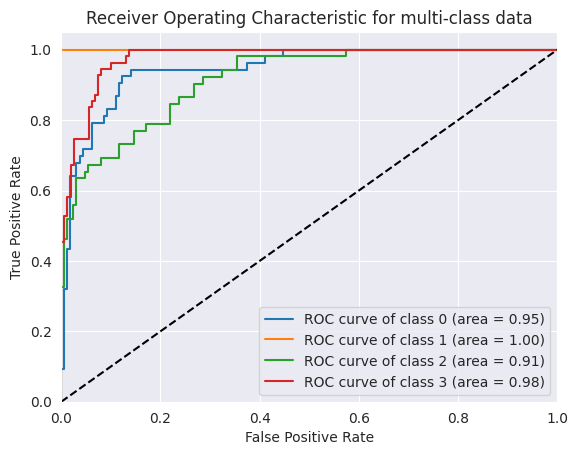

In [23]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [24]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
# grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


94765736/94765736 [==============================] - 4s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 3)       30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_6 (Dense)             (None, 4)                 4100 

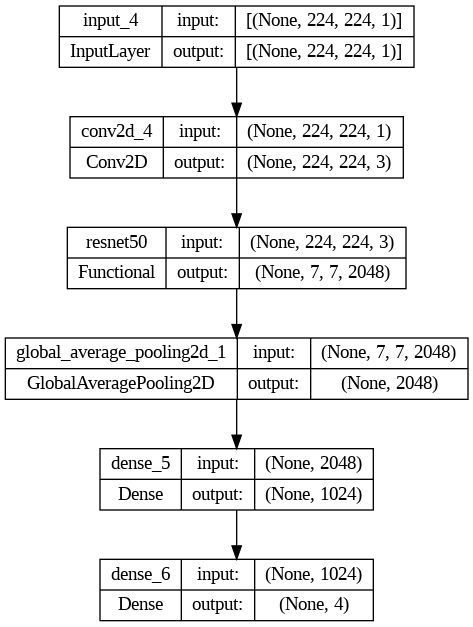

In [25]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [26]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [27]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
239/239 [==============================] - 41s 146ms/step - loss: 0.6439 - accuracy: 0.7661 - val_loss: 0.4447 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 33s 137ms/step - loss: 0.3571 - accuracy: 0.8626 - val_loss: 0.3669 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 32s 136ms/step - loss: 0.3061 - accuracy: 0.8778 - val_loss: 0.3185 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 33s 137ms/step - loss: 0.2856 - accuracy: 0.8857 - val_loss: 0.3569 - val_accuracy: 0.8421 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 33s 136ms/step - loss: 0.2842 - accuracy: 0.8885 - val_loss: 0.3180 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 33s 136ms/step - loss: 0.2651 - accuracy: 0.8961 - val_loss: 0.2974 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 7/20
239/239 [==============================] 

ResNet50 Evaluation

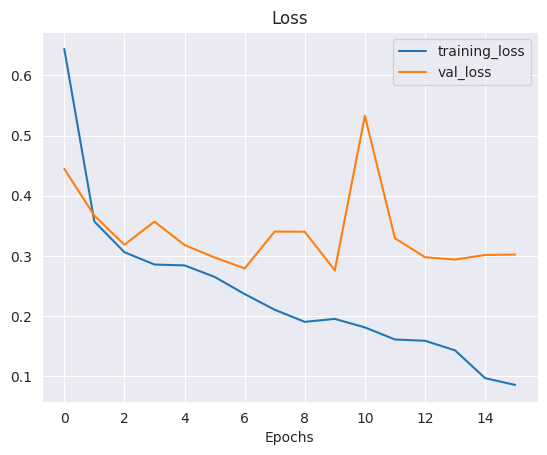

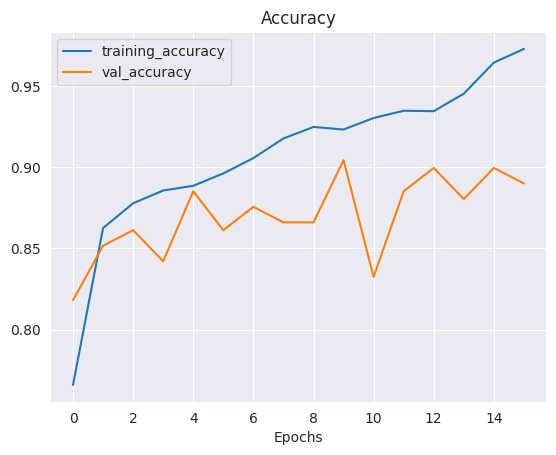

In [28]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 50ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        53
           1       0.98      0.98      0.98        56
           2       0.81      0.85      0.83        52
           3       0.90      0.85      0.88        55

    accuracy                           0.90       216
   macro avg       0.90      0.90      0.90       216
weighted avg       0.90      0.90      0.90       216

Specificity: [0.2857142857142857, 0.3416149068322981, 0.2558139534883721, 0.2781065088757396]
Mean Squared Error: : 0.10747785866260529
The average AUC-ROC is 0.9841232447087753


[0.9691358024691358,
 0.66875,
 0.6975308641975309,
 0.6829268292682927,
 0.654320987654321,
 0.99375,
 0.6604938271604939,
 0.6585365853658537,
 0.7037037037037037,
 0.675,
 0.9506172839506173,
 0.7073170731707317,
 0.6728395061728395,
 0.6625,
 0.691358024691358,
 0.9512195121951219]

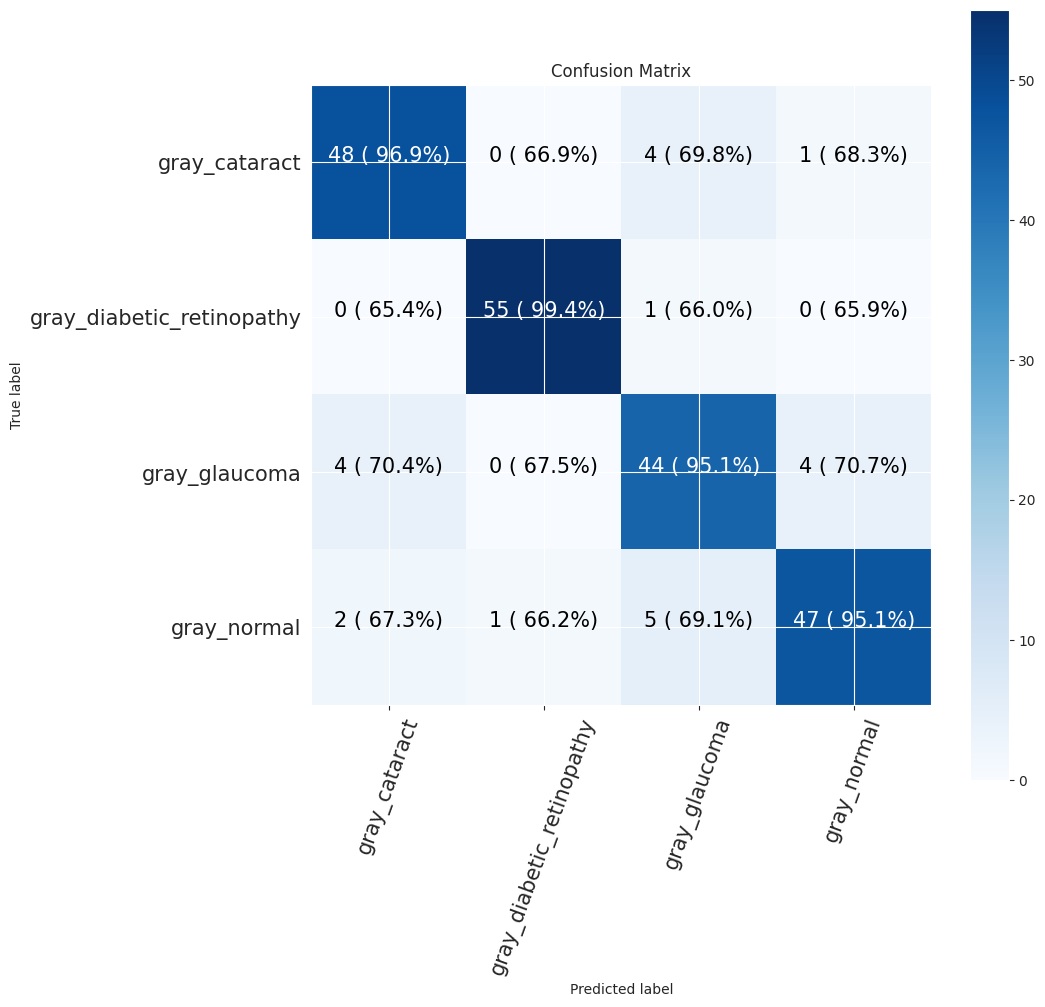

In [29]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


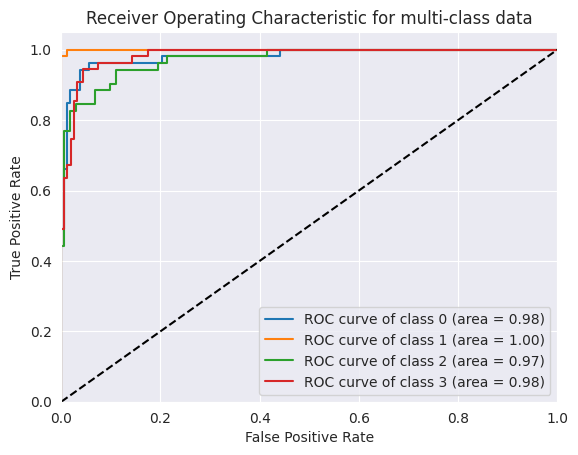

In [30]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [31]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
# grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


171446536/171446536 [==============================] - 8s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 3)       30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_8 (Dense)             (None, 4)                 410

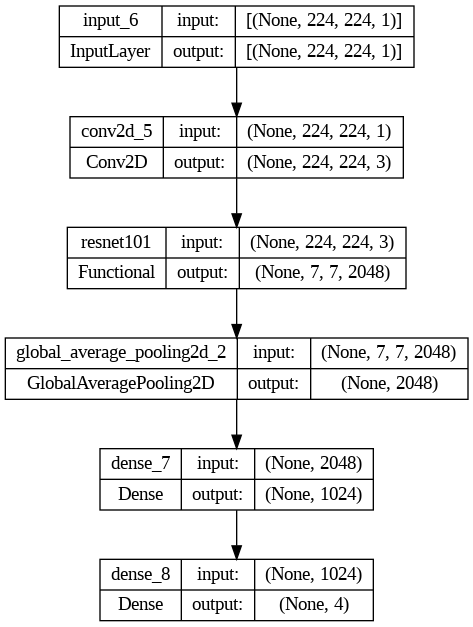

In [32]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [33]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [34]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
239/239 [==============================] - 63s 235ms/step - loss: 0.6029 - accuracy: 0.7905 - val_loss: 0.4958 - val_accuracy: 0.8278 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 53s 224ms/step - loss: 0.3590 - accuracy: 0.8607 - val_loss: 0.4288 - val_accuracy: 0.8230 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 54s 225ms/step - loss: 0.3057 - accuracy: 0.8809 - val_loss: 0.3628 - val_accuracy: 0.8325 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 54s 225ms/step - loss: 0.2821 - accuracy: 0.8946 - val_loss: 0.3983 - val_accuracy: 0.8421 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 54s 225ms/step - loss: 0.2757 - accuracy: 0.8933 - val_loss: 0.4537 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 54s 225ms/step - loss: 0.2578 - accuracy: 0.8951 - val_loss: 0.4033 - val_accuracy: 0.8278 - lr: 0.0010
Epoch 7/20
239/239 [==============================] 

ResNet101 Evaluation

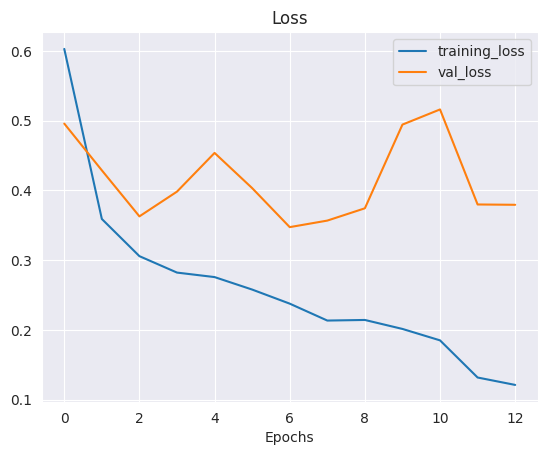

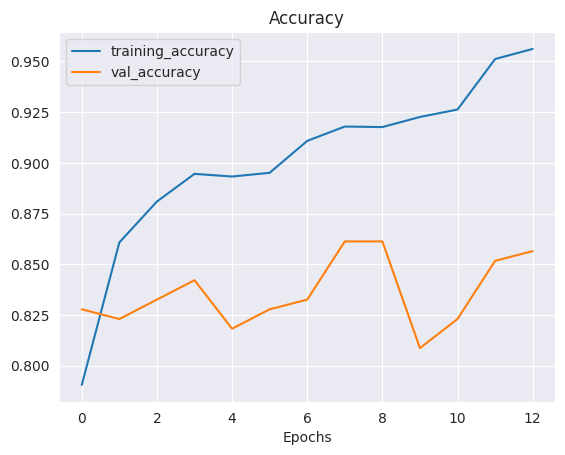

In [35]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 86ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91        53
           1       1.00      0.96      0.98        56
           2       0.77      0.85      0.81        52
           3       0.87      0.84      0.85        55

    accuracy                           0.89       216
   macro avg       0.89      0.89      0.89       216
weighted avg       0.89      0.89      0.89       216

Specificity: [0.2857142857142857, 0.3333333333333333, 0.2558139534883721, 0.27058823529411763]
Mean Squared Error: : 0.11216668784618378
The average AUC-ROC is 0.9795369622776983


[0.9695121951219512,
 0.6728395061728395,
 0.6981132075471698,
 0.6748466257668712,
 0.6585365853658537,
 0.9876543209876543,
 0.6477987421383647,
 0.6687116564417178,
 0.7012195121951219,
 0.6790123456790124,
 0.949685534591195,
 0.7116564417177914,
 0.6707317073170732,
 0.6604938271604939,
 0.7044025157232704,
 0.9447852760736196]

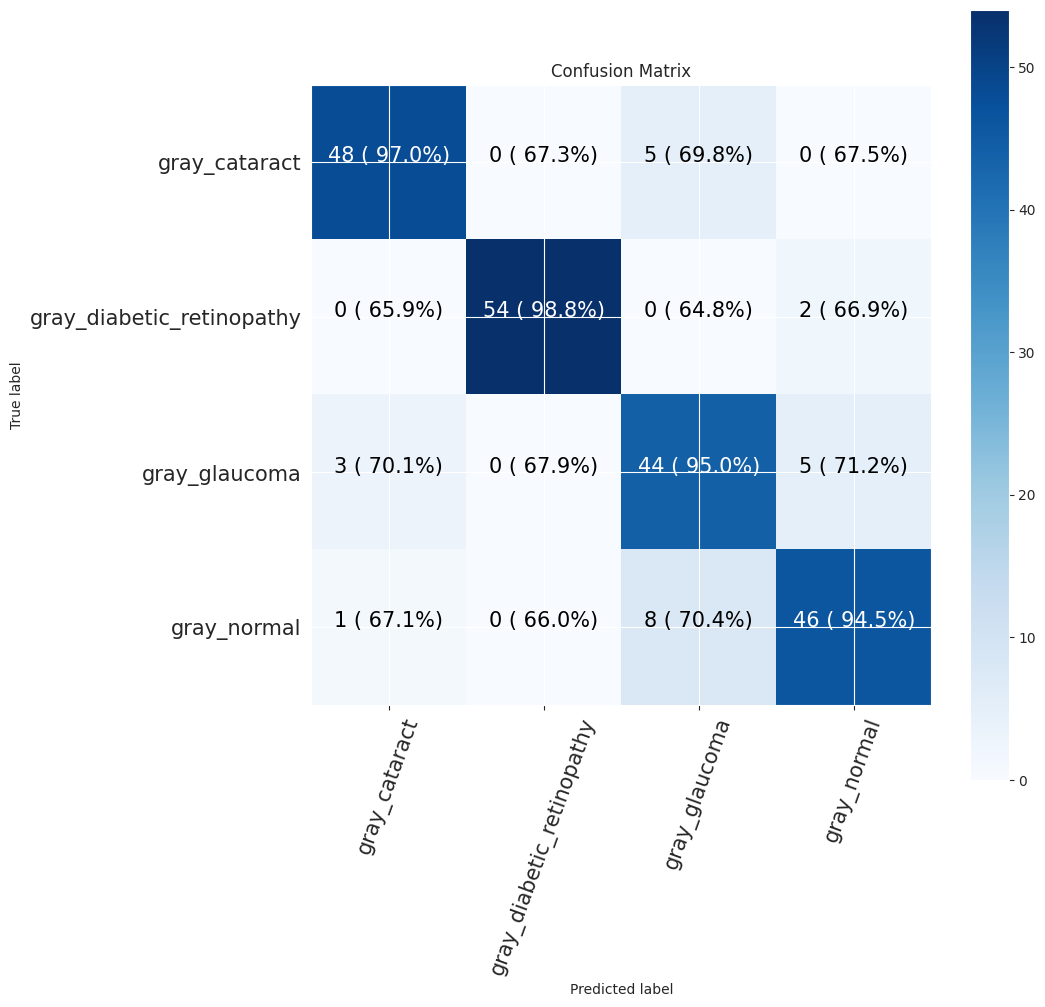

In [36]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


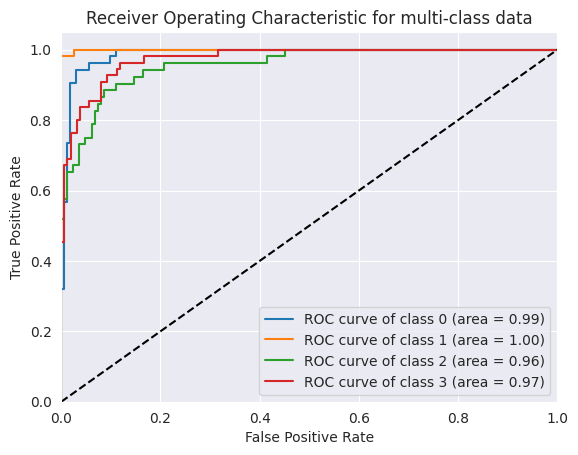

In [37]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 32**

In [38]:
epoch = 20
batchsize = 32

In [39]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3813 files belonging to 4 classes.
Found 216 files belonging to 4 classes.
Found 209 files belonging to 4 classes.


# **EfficientNetV2B3 Model**

In [40]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [41]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_3  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 32)                49184     
                                                                 
 dense_10 (Dense)            (None, 4)                 132       
                                                                 
 activation_1 (Activation)   (None, 4)                 0   

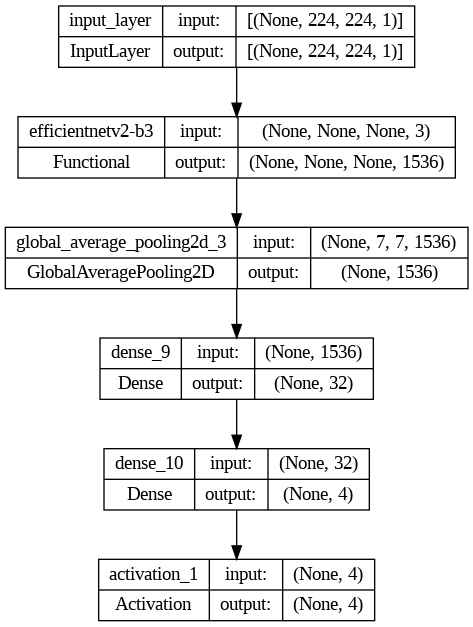

In [42]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [43]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [44]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
120/120 [==============================] - 26s 122ms/step - loss: 0.6737 - accuracy: 0.7301 - val_loss: 0.4897 - val_accuracy: 0.8230 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 11s 94ms/step - loss: 0.4760 - accuracy: 0.8177 - val_loss: 0.3861 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 11s 95ms/step - loss: 0.4264 - accuracy: 0.8421 - val_loss: 0.3277 - val_accuracy: 0.8804 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 11s 93ms/step - loss: 0.3804 - accuracy: 0.8579 - val_loss: 0.3214 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 11s 92ms/step - loss: 0.3686 - accuracy: 0.8542 - val_loss: 0.3555 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 11s 92ms/step - loss: 0.3580 - accuracy: 0.8655 - val_loss: 0.3119 - val_accuracy: 0.8756 - lr: 0.0010
Epoch 7/20
120/120 [==============================] - 11s

EfficientNetV2B3 Evaluation

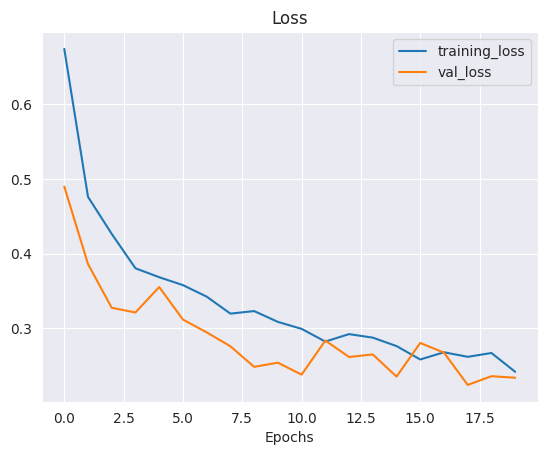

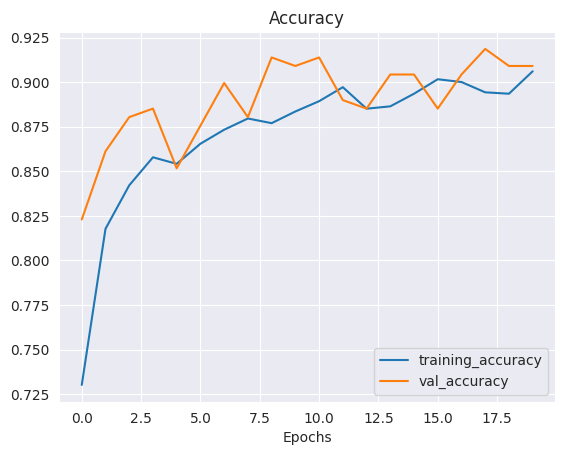

In [45]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 79ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        53
           1       0.98      0.98      0.98        56
           2       0.89      0.79      0.84        52
           3       0.85      0.96      0.91        55

    accuracy                           0.92       216
   macro avg       0.92      0.91      0.91       216
weighted avg       0.92      0.92      0.92       216

Specificity: [0.2934131736526946, 0.3416149068322981, 0.2342857142857143, 0.32515337423312884]
Mean Squared Error: : 0.10898864269256592
The average AUC-ROC is 0.9878887009966084


[0.975609756097561,
 0.66875,
 0.7058823529411765,
 0.6623376623376623,
 0.6585365853658537,
 0.99375,
 0.6705882352941176,
 0.6428571428571429,
 0.7012195121951219,
 0.68125,
 0.9352941176470588,
 0.7077922077922078,
 0.6646341463414634,
 0.65625,
 0.6882352941176471,
 0.987012987012987]

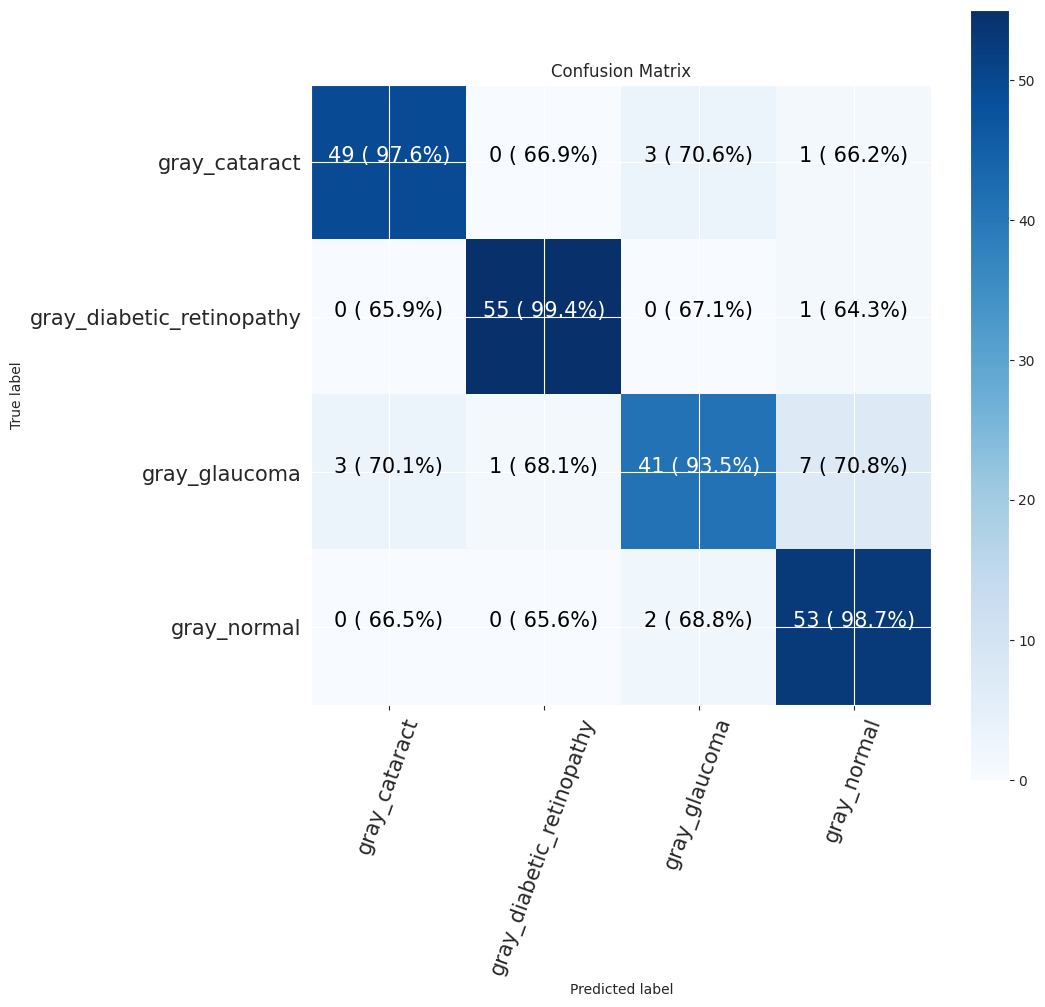

In [46]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


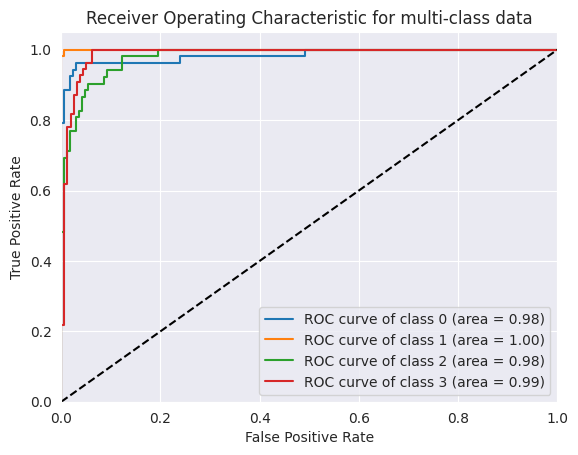

In [47]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [48]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 26, 26, 128)      

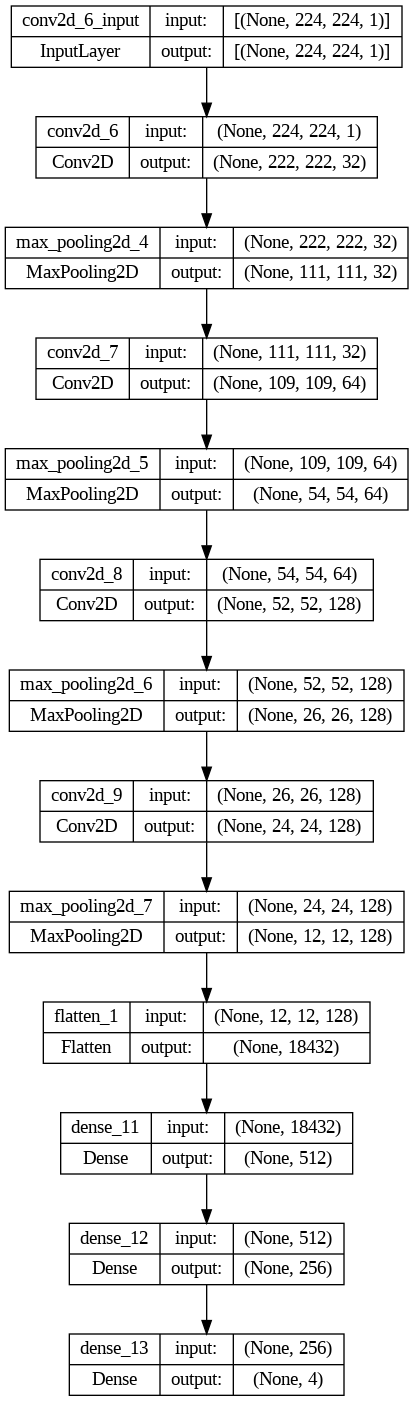

In [49]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [50]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [51]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
120/120 [==============================] - 7s 37ms/step - loss: 3.3237 - accuracy: 0.5547 - val_loss: 0.7624 - val_accuracy: 0.6603 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 4s 35ms/step - loss: 1.2805 - accuracy: 0.6412 - val_loss: 0.7361 - val_accuracy: 0.6603 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 4s 35ms/step - loss: 0.6768 - accuracy: 0.6853 - val_loss: 0.6798 - val_accuracy: 0.6603 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 4s 35ms/step - loss: 0.6351 - accuracy: 0.7105 - val_loss: 0.6095 - val_accuracy: 0.7129 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 4s 35ms/step - loss: 0.6147 - accuracy: 0.7189 - val_loss: 0.6388 - val_accuracy: 0.6842 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 4s 35ms/step - loss: 0.6139 - accuracy: 0.7175 - val_loss: 0.6400 - val_accuracy: 0.7081 - lr: 0.0010
Epoch 7/20
120/120 [==============================] - 4s 35ms/st

CNN Evaluation

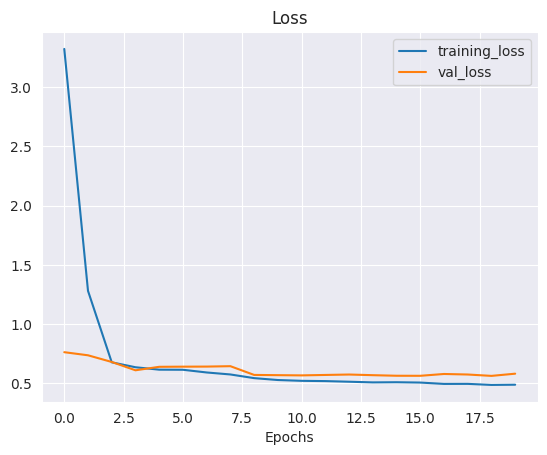

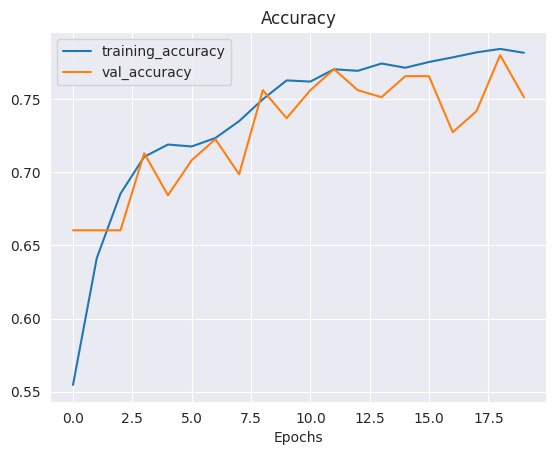

In [52]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 13ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.55      0.61        53
           1       1.00      1.00      1.00        56
           2       0.61      0.52      0.56        52
           3       0.72      0.96      0.82        55

    accuracy                           0.76       216
   macro avg       0.76      0.76      0.75       216
weighted avg       0.76      0.76      0.75       216

Specificity: [0.15508021390374332, 0.35, 0.14285714285714285, 0.32515337423312884]
Mean Squared Error: : 0.13639508187770844
The average AUC-ROC is 0.9044007829084291


[0.8620689655172413,
 0.66875,
 0.7790697674418605,
 0.6901408450704225,
 0.6781609195402298,
 1.0,
 0.6744186046511628,
 0.6056338028169014,
 0.7758620689655172,
 0.675,
 0.8546511627906976,
 0.7183098591549296,
 0.6839080459770115,
 0.65625,
 0.6918604651162791,
 0.9859154929577465]

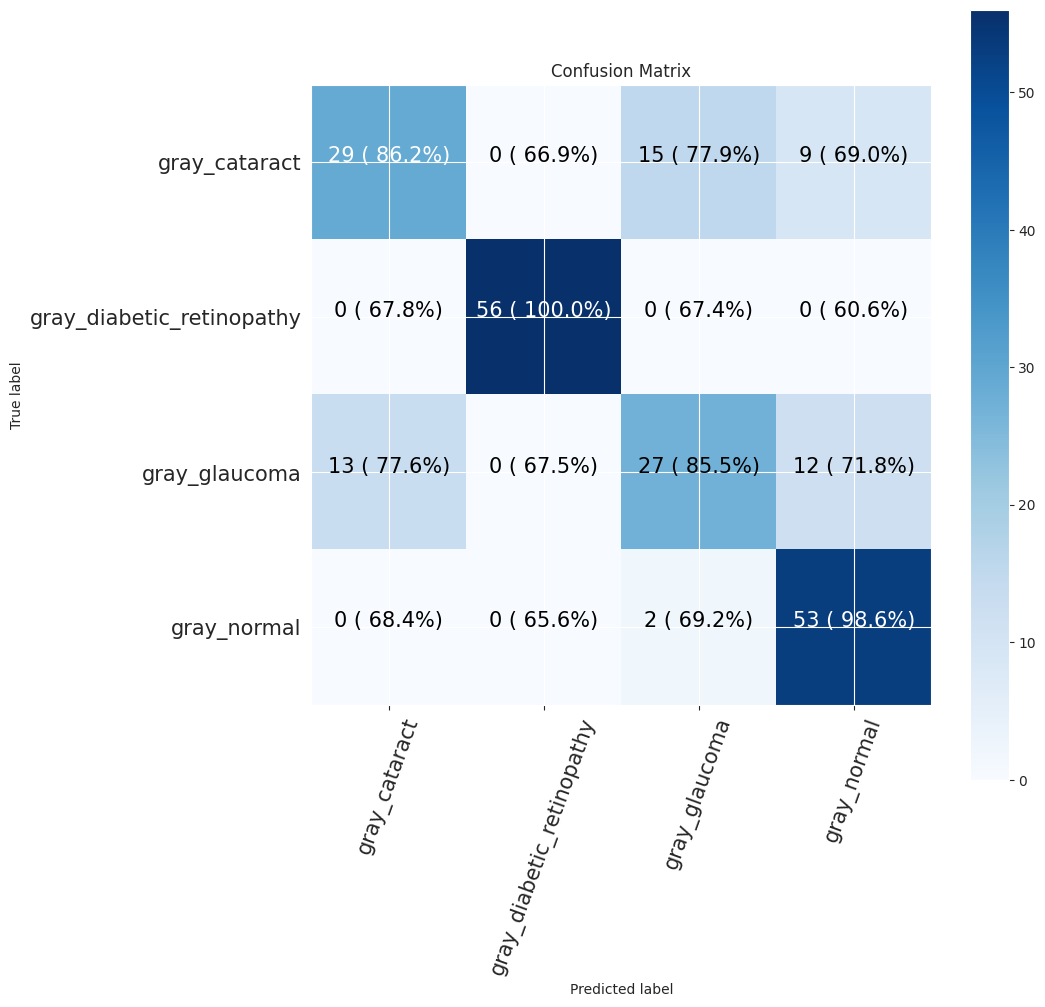

In [53]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


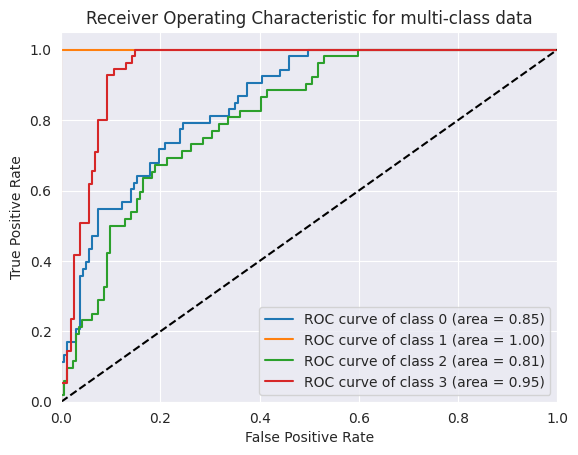

In [54]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [55]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
# grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 224, 224, 3)       30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_15 (Dense)            (None, 4)                 4100      
                                                           

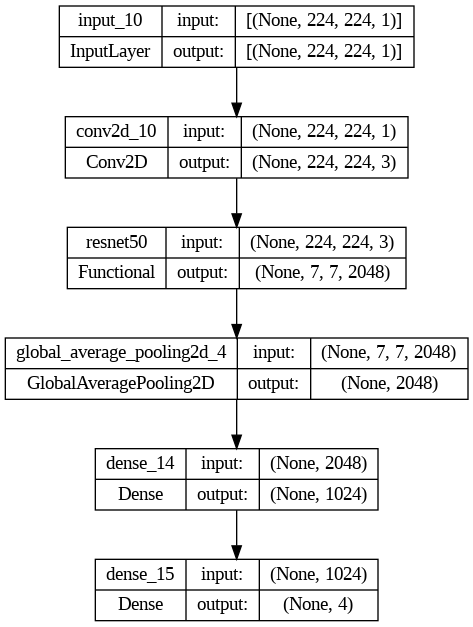

In [56]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [57]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [58]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
120/120 [==============================] - 39s 277ms/step - loss: 0.6871 - accuracy: 0.7606 - val_loss: 0.3939 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 31s 260ms/step - loss: 0.3687 - accuracy: 0.8560 - val_loss: 0.3270 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 31s 260ms/step - loss: 0.2986 - accuracy: 0.8857 - val_loss: 0.3846 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 31s 261ms/step - loss: 0.2817 - accuracy: 0.8822 - val_loss: 0.3423 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 31s 260ms/step - loss: 0.2232 - accuracy: 0.9137 - val_loss: 0.3514 - val_accuracy: 0.8708 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 31s 260ms/step - loss: 0.1996 - accuracy: 0.9242 - val_loss: 0.3886 - val_accuracy: 0.8708 - lr: 0.0010
Epoch 7/20
120/120 [==============================] 

ResNet50 Evaluation

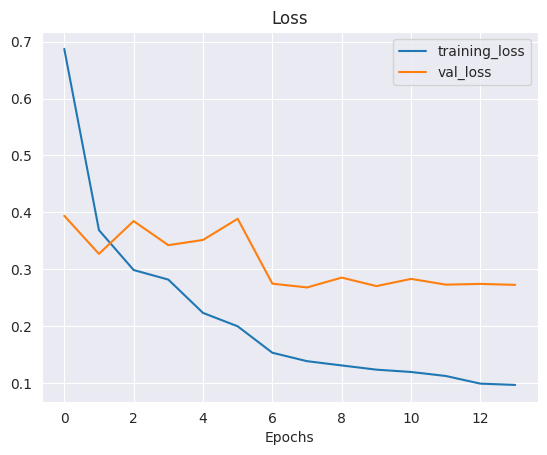

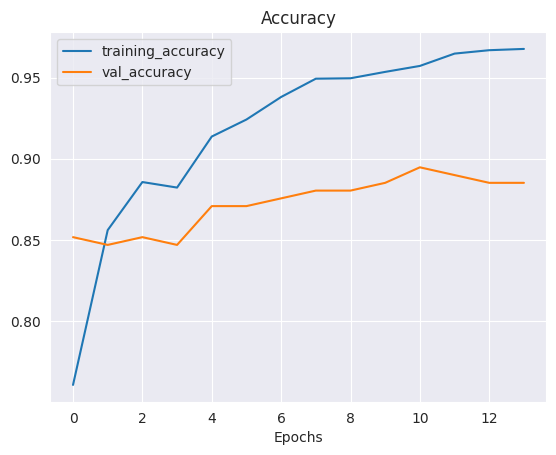

In [59]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 95ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        53
           1       0.98      1.00      0.99        56
           2       0.91      0.81      0.86        52
           3       0.88      0.96      0.92        55

    accuracy                           0.92       216
   macro avg       0.92      0.92      0.92       216
weighted avg       0.92      0.92      0.92       216

Specificity: [0.2857142857142857, 0.35, 0.2413793103448276, 0.32515337423312884]
Mean Squared Error: : 0.10674556344747543
The average AUC-ROC is 0.9886639211155202


[0.9693251533742331,
 0.6729559748427673,
 0.7058823529411765,
 0.6666666666666666,
 0.656441717791411,
 1.0,
 0.6705882352941176,
 0.6410256410256411,
 0.7055214723926381,
 0.6729559748427673,
 0.9411764705882353,
 0.7051282051282052,
 0.6687116564417178,
 0.6540880503144654,
 0.6823529411764706,
 0.9871794871794872]

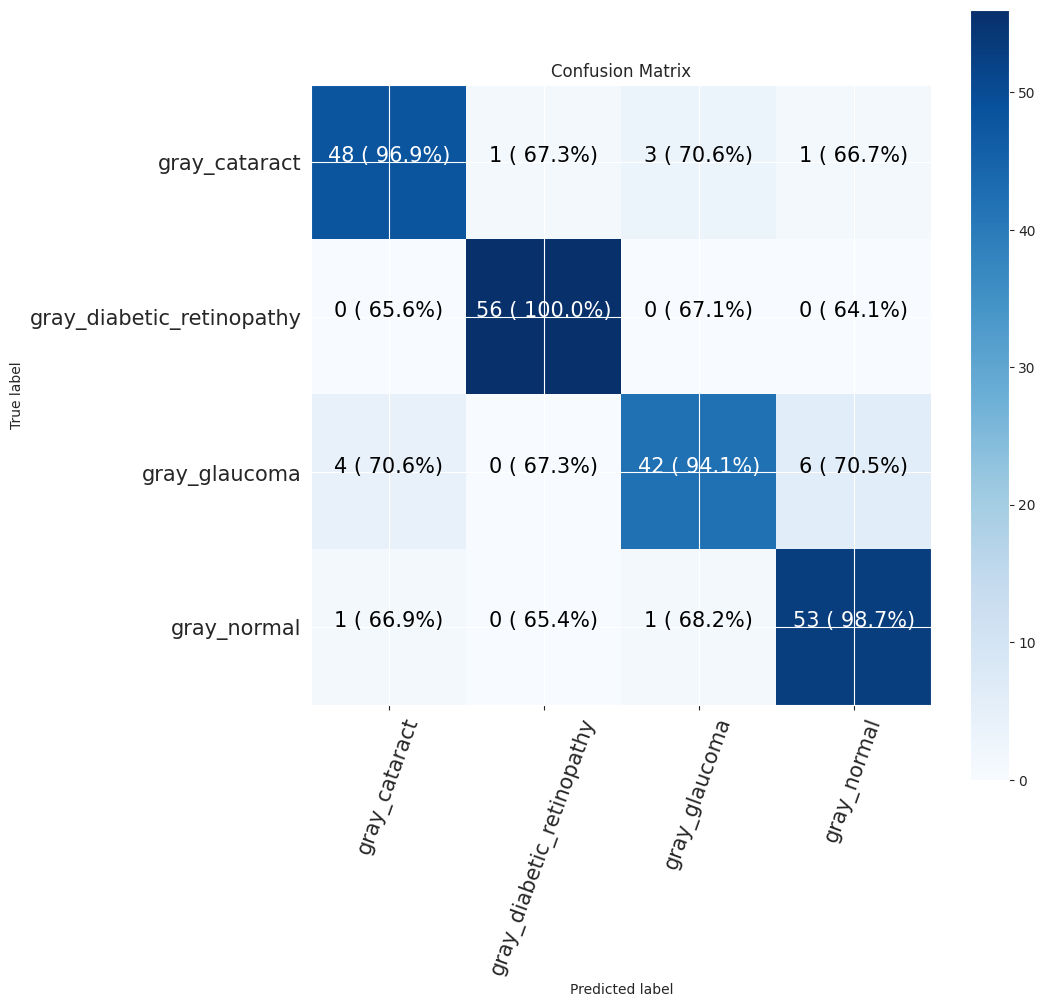

In [60]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


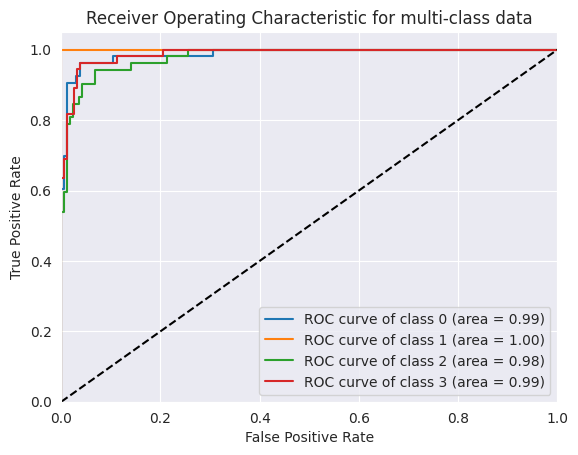

In [61]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [62]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
# grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 224, 224, 3)       30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_16 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_17 (Dense)            (None, 4)                 4100      
                                                           

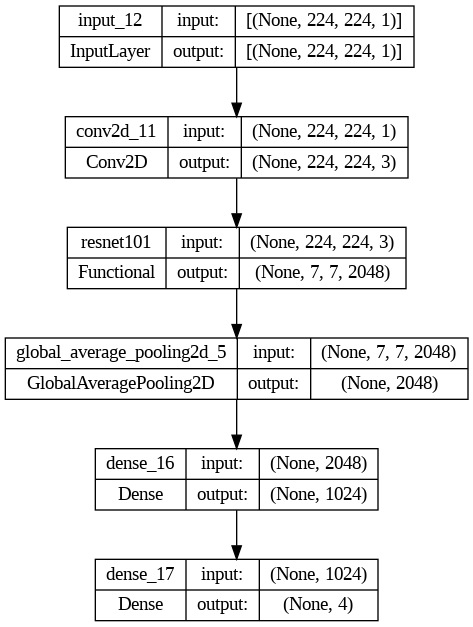

In [63]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [64]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [65]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
120/120 [==============================] - 61s 453ms/step - loss: 0.6471 - accuracy: 0.7836 - val_loss: 0.4074 - val_accuracy: 0.8325 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 51s 427ms/step - loss: 0.3752 - accuracy: 0.8550 - val_loss: 0.3527 - val_accuracy: 0.8565 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 52s 430ms/step - loss: 0.3286 - accuracy: 0.8678 - val_loss: 0.3462 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 52s 430ms/step - loss: 0.2700 - accuracy: 0.8954 - val_loss: 0.3654 - val_accuracy: 0.8325 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 52s 431ms/step - loss: 0.2883 - accuracy: 0.8857 - val_loss: 0.2958 - val_accuracy: 0.8756 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 52s 429ms/step - loss: 0.2451 - accuracy: 0.9045 - val_loss: 0.3545 - val_accuracy: 0.8565 - lr: 0.0010
Epoch 7/20
120/120 [==============================] 

ResNet101 Evaluation

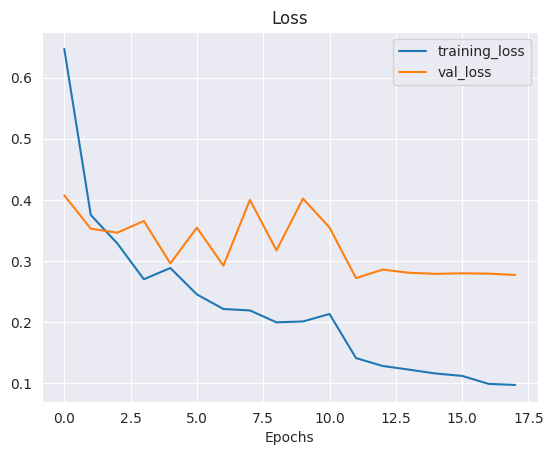

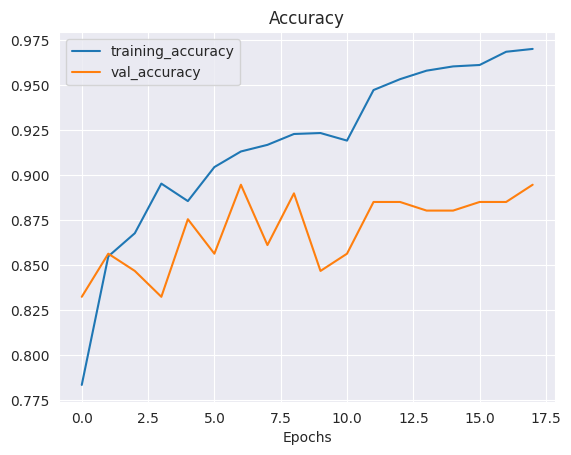

In [66]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 163ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87        53
           1       1.00      0.96      0.98        56
           2       0.84      0.73      0.78        52
           3       0.85      0.93      0.89        55

    accuracy                           0.88       216
   macro avg       0.88      0.88      0.88       216
weighted avg       0.89      0.88      0.88       216

Specificity: [0.2857142857142857, 0.3333333333333333, 0.21348314606741572, 0.3090909090909091]
Mean Squared Error: : 0.11087427288293839
The average AUC-ROC is 0.9812568033361115


[0.9685534591194969,
 0.6728395061728395,
 0.7134502923976608,
 0.6666666666666666,
 0.6477987421383647,
 0.9876543209876543,
 0.672514619883041,
 0.6538461538461539,
 0.7232704402515723,
 0.6790123456790124,
 0.9181286549707602,
 0.7051282051282052,
 0.660377358490566,
 0.6604938271604939,
 0.695906432748538,
 0.9743589743589743]

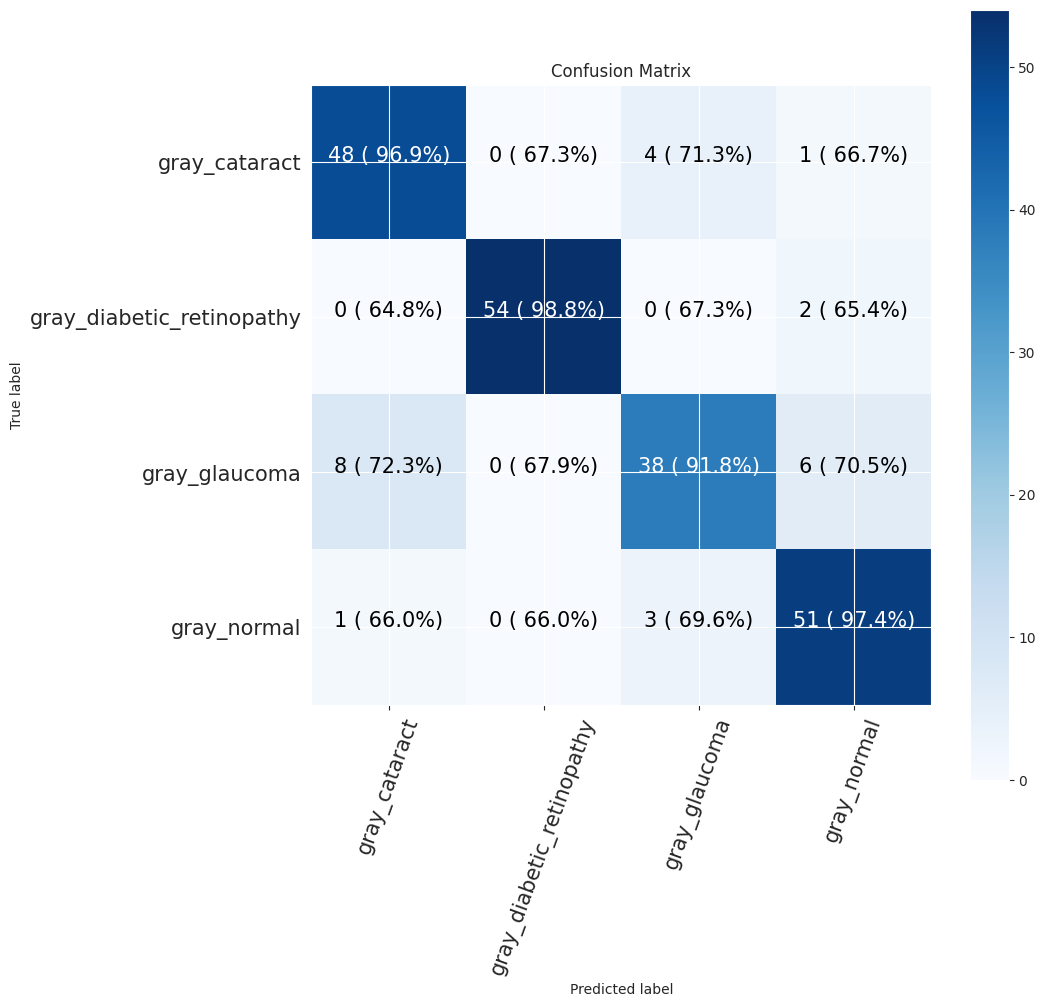

In [67]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


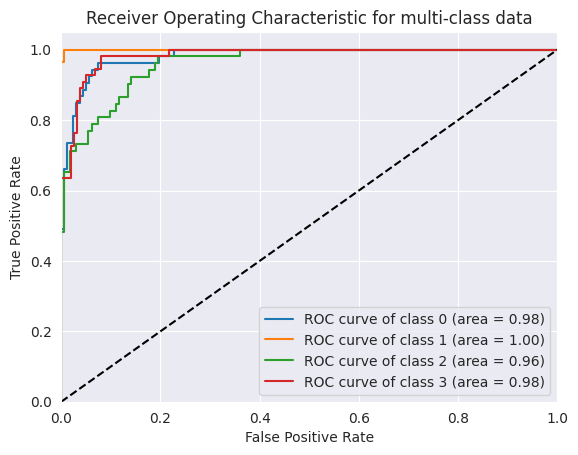

In [68]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 64**

In [82]:
epoch = 20
batchsize = 64

In [83]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3813 files belonging to 4 classes.
Found 216 files belonging to 4 classes.
Found 209 files belonging to 4 classes.


# **EfficientNetV2B3 Model**

In [84]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [85]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_7  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_20 (Dense)            (None, 32)                49184     
                                                                 
 dense_21 (Dense)            (None, 4)                 132       
                                                                 
 activation_3 (Activation)   (None, 4)                 0   

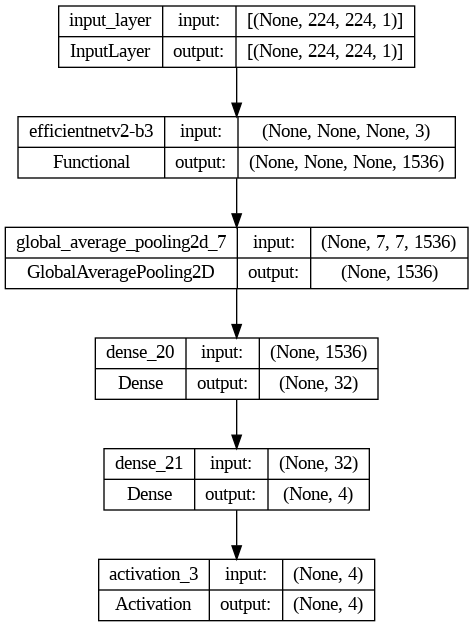

In [86]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [87]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [88]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
60/60 [==============================] - 23s 219ms/step - loss: 0.6944 - accuracy: 0.7194 - val_loss: 0.4609 - val_accuracy: 0.8134 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 11s 182ms/step - loss: 0.4765 - accuracy: 0.8154 - val_loss: 0.4089 - val_accuracy: 0.8325 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 11s 178ms/step - loss: 0.4279 - accuracy: 0.8384 - val_loss: 0.3497 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 11s 176ms/step - loss: 0.3916 - accuracy: 0.8547 - val_loss: 0.3378 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 11s 174ms/step - loss: 0.3922 - accuracy: 0.8463 - val_loss: 0.3155 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 11s 174ms/step - loss: 0.3521 - accuracy: 0.8691 - val_loss: 0.3059 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 11s 175ms/st

EfficientNetV2B3 Evaluation

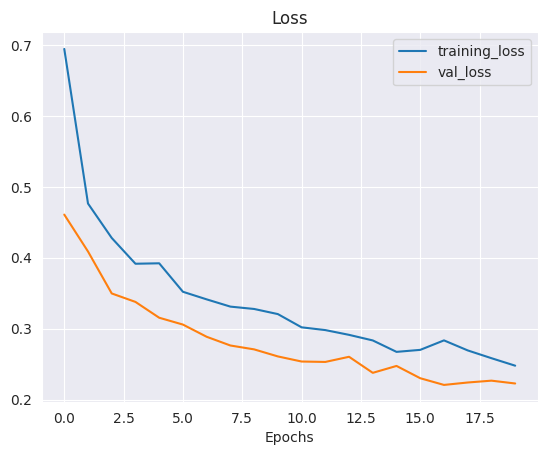

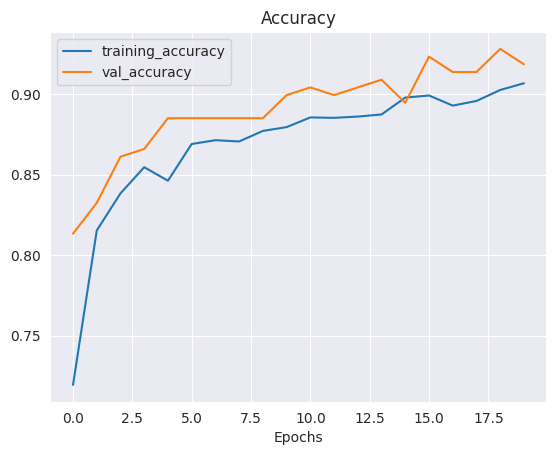

In [89]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 148ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        53
           1       0.98      1.00      0.99        56
           2       0.88      0.87      0.87        52
           3       0.91      0.93      0.92        55

    accuracy                           0.93       216
   macro avg       0.93      0.93      0.93       216
weighted avg       0.93      0.93      0.93       216

Specificity: [0.2934131736526946, 0.35, 0.2631578947368421, 0.3090909090909091]
Mean Squared Error: : 0.1093929260969162
The average AUC-ROC is 0.9872246676392942


[0.975609756097561,
 0.6666666666666666,
 0.696969696969697,
 0.675,
 0.6585365853658537,
 1.0,
 0.6606060606060606,
 0.65,
 0.6951219512195121,
 0.6792452830188679,
 0.9575757575757575,
 0.7,
 0.6707317073170732,
 0.6540880503144654,
 0.6848484848484848,
 0.975]

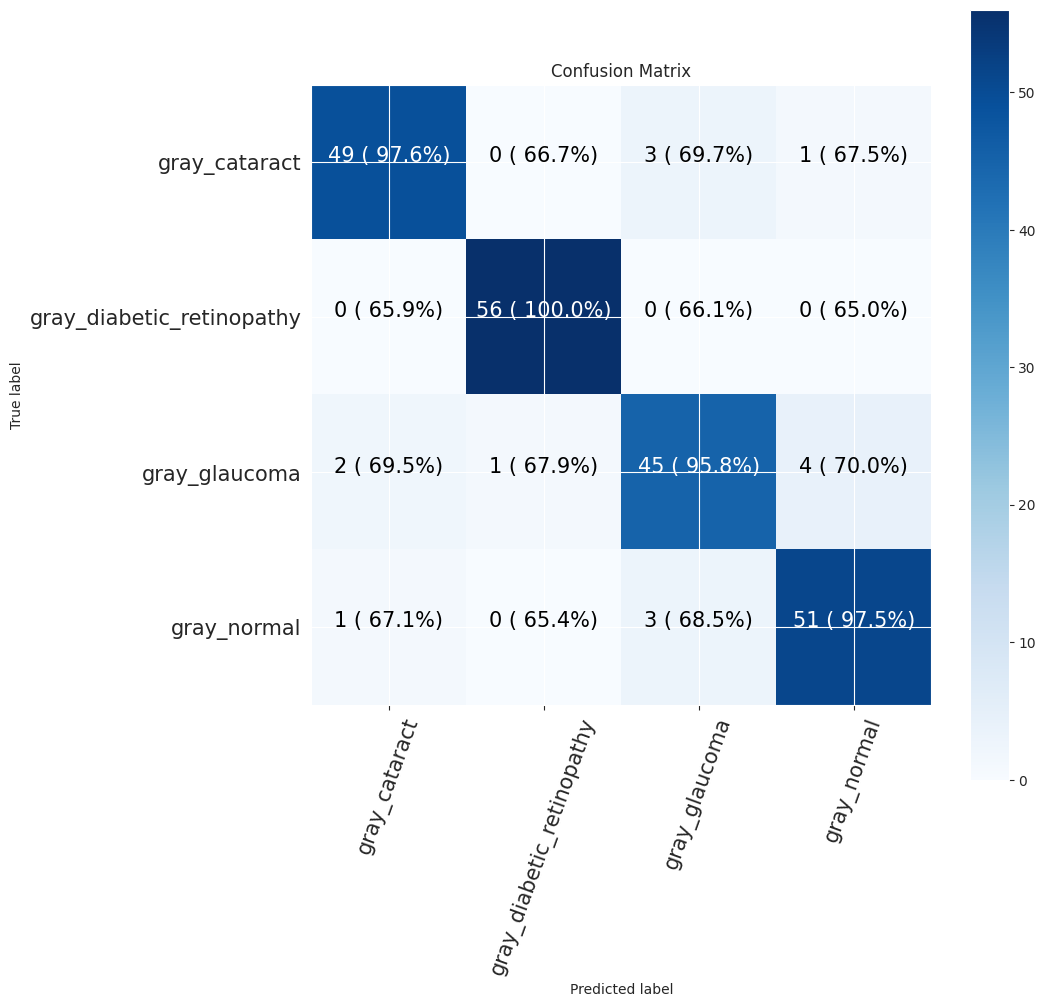

In [90]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


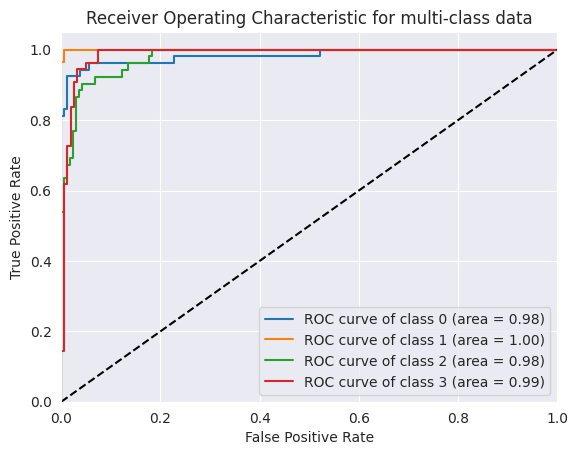

In [91]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [92]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 26, 26, 128)      

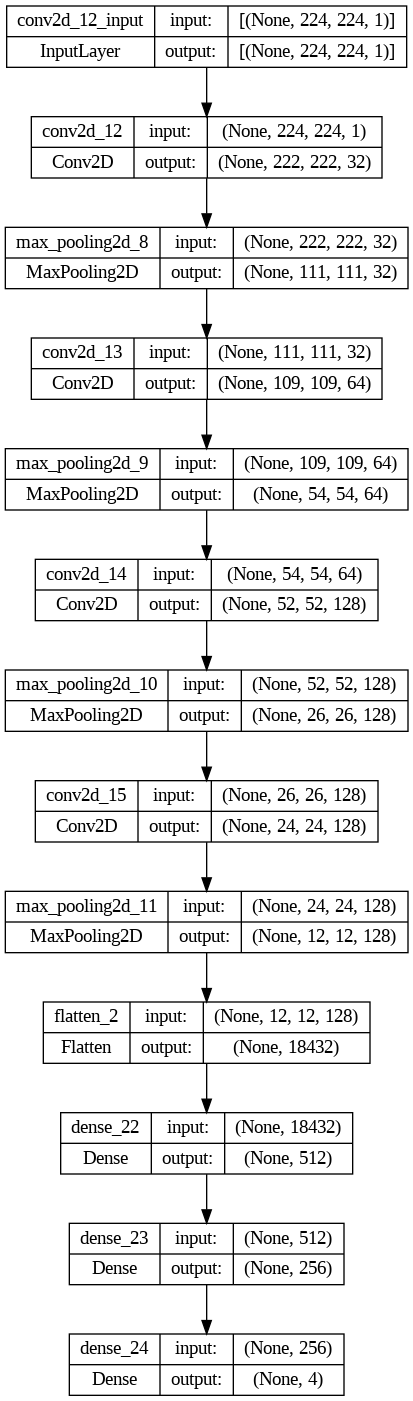

In [93]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [94]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [95]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
60/60 [==============================] - 8s 80ms/step - loss: 4.6948 - accuracy: 0.5132 - val_loss: 0.7515 - val_accuracy: 0.6220 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 4s 66ms/step - loss: 0.6794 - accuracy: 0.7063 - val_loss: 0.6612 - val_accuracy: 0.7129 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 4s 66ms/step - loss: 0.6172 - accuracy: 0.7265 - val_loss: 0.5551 - val_accuracy: 0.7464 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 4s 66ms/step - loss: 0.5372 - accuracy: 0.7632 - val_loss: 0.5633 - val_accuracy: 0.6842 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 4s 66ms/step - loss: 0.5000 - accuracy: 0.7792 - val_loss: 0.5273 - val_accuracy: 0.7560 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 4s 66ms/step - loss: 0.4433 - accuracy: 0.8183 - val_loss: 0.4397 - val_accuracy: 0.8134 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 4s 66ms/step - loss: 0.3

CNN Evaluation

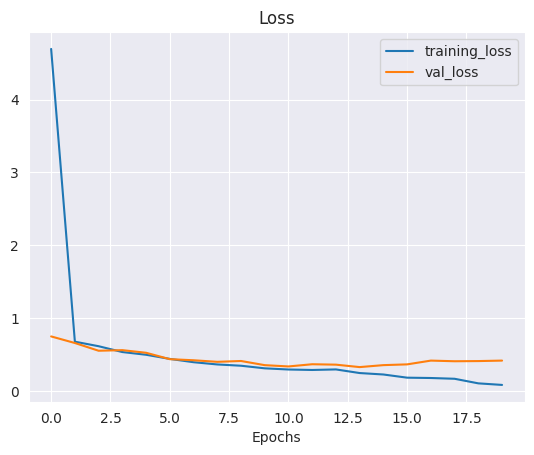

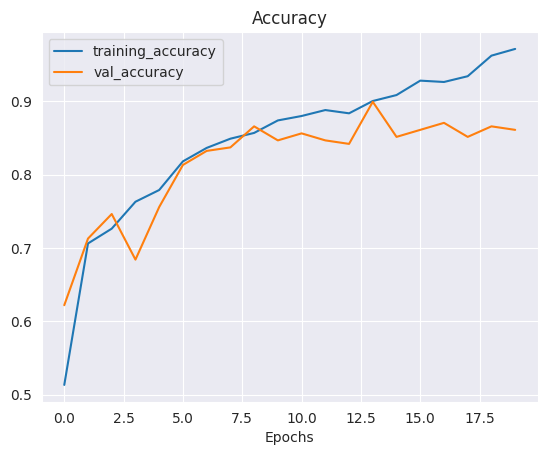

In [96]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 25ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        53
           1       1.00      0.98      0.99        56
           2       0.81      0.75      0.78        52
           3       0.83      0.91      0.87        55

    accuracy                           0.88       216
   macro avg       0.88      0.88      0.88       216
weighted avg       0.88      0.88      0.88       216

Specificity: [0.2781065088757396, 0.3416149068322981, 0.22033898305084745, 0.30120481927710846]
Mean Squared Error: : 0.11150150746107101
The average AUC-ROC is 0.9637934417841273


[0.9631901840490797,
 0.6708074534161491,
 0.7083333333333334,
 0.6730769230769231,
 0.656441717791411,
 0.9937888198757764,
 0.6666666666666666,
 0.6474358974358975,
 0.7177914110429447,
 0.6770186335403726,
 0.9226190476190477,
 0.7115384615384616,
 0.6625766871165644,
 0.6583850931677019,
 0.7023809523809523,
 0.967948717948718]

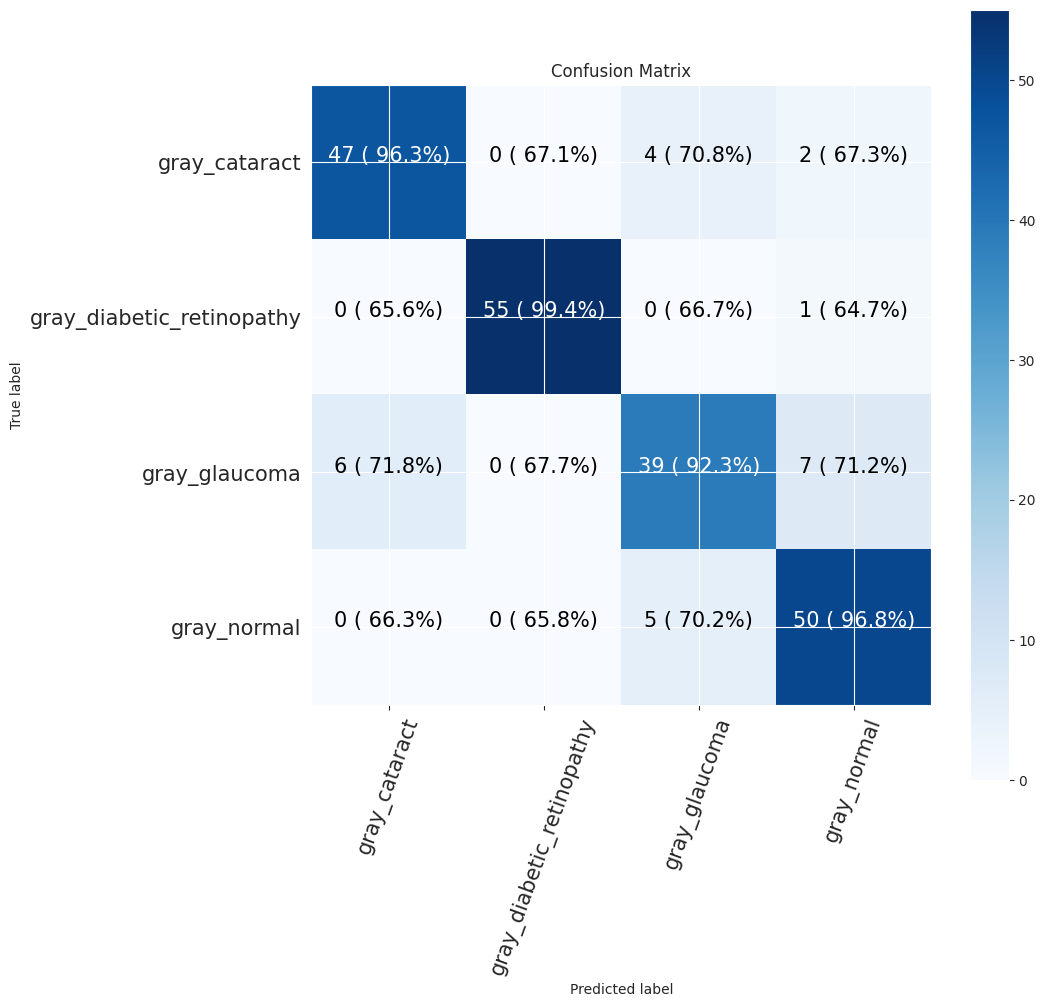

In [97]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


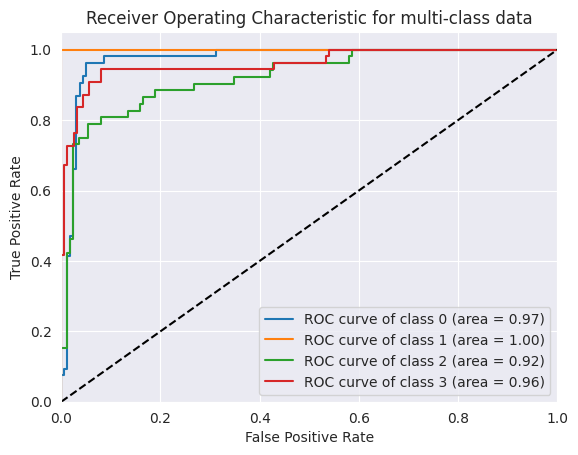

In [98]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [99]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
# grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 3)       30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_8  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_25 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_26 (Dense)            (None, 4)                 4100      
                                                           

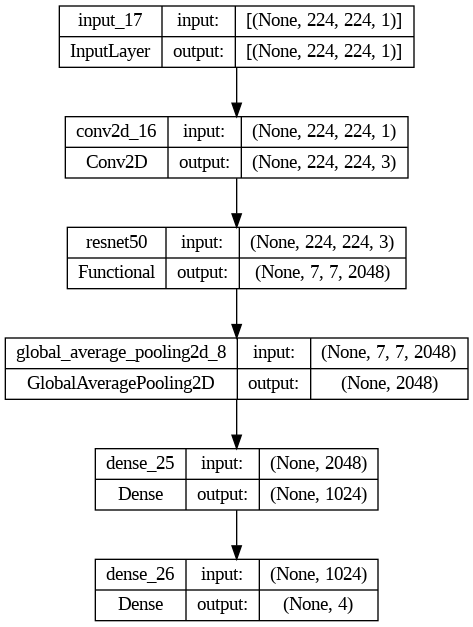

In [100]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [101]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [102]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
60/60 [==============================] - 42s 570ms/step - loss: 0.7676 - accuracy: 0.7309 - val_loss: 0.4219 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 30s 504ms/step - loss: 0.4001 - accuracy: 0.8471 - val_loss: 0.3755 - val_accuracy: 0.8421 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 30s 503ms/step - loss: 0.3263 - accuracy: 0.8739 - val_loss: 0.3398 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 31s 508ms/step - loss: 0.3051 - accuracy: 0.8809 - val_loss: 0.3294 - val_accuracy: 0.8756 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 31s 507ms/step - loss: 0.2898 - accuracy: 0.8857 - val_loss: 0.4725 - val_accuracy: 0.8325 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 31s 507ms/step - loss: 0.2815 - accuracy: 0.8909 - val_loss: 0.3275 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 31s 507ms/st

ResNet50 Evaluation

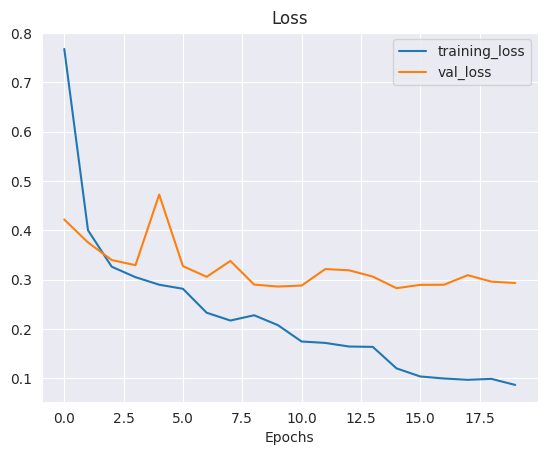

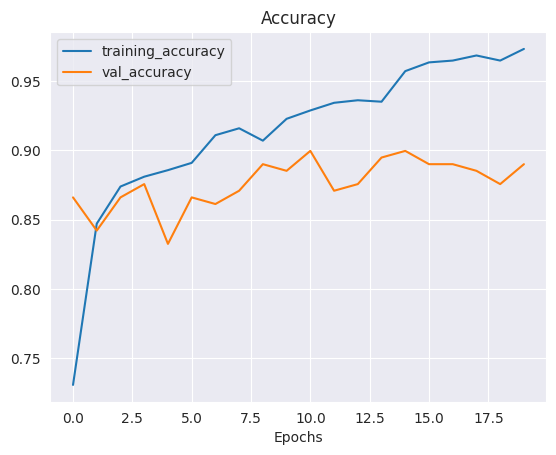

In [103]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 183ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        53
           1       1.00      0.98      0.99        56
           2       0.89      0.81      0.85        52
           3       0.89      0.91      0.90        55

    accuracy                           0.91       216
   macro avg       0.91      0.91      0.91       216
weighted avg       0.91      0.91      0.91       216

Specificity: [0.30120481927710846, 0.3416149068322981, 0.2413793103448276, 0.30120481927710846]
Mean Squared Error: : 0.10798683762550354
The average AUC-ROC is 0.9835658809194008


[0.9810126582278481,
 0.6708074534161491,
 0.6982248520710059,
 0.675,
 0.6455696202531646,
 0.9937888198757764,
 0.6686390532544378,
 0.65625,
 0.7088607594936709,
 0.6770186335403726,
 0.9408284023668639,
 0.7,
 0.6645569620253164,
 0.6583850931677019,
 0.6923076923076923,
 0.96875]

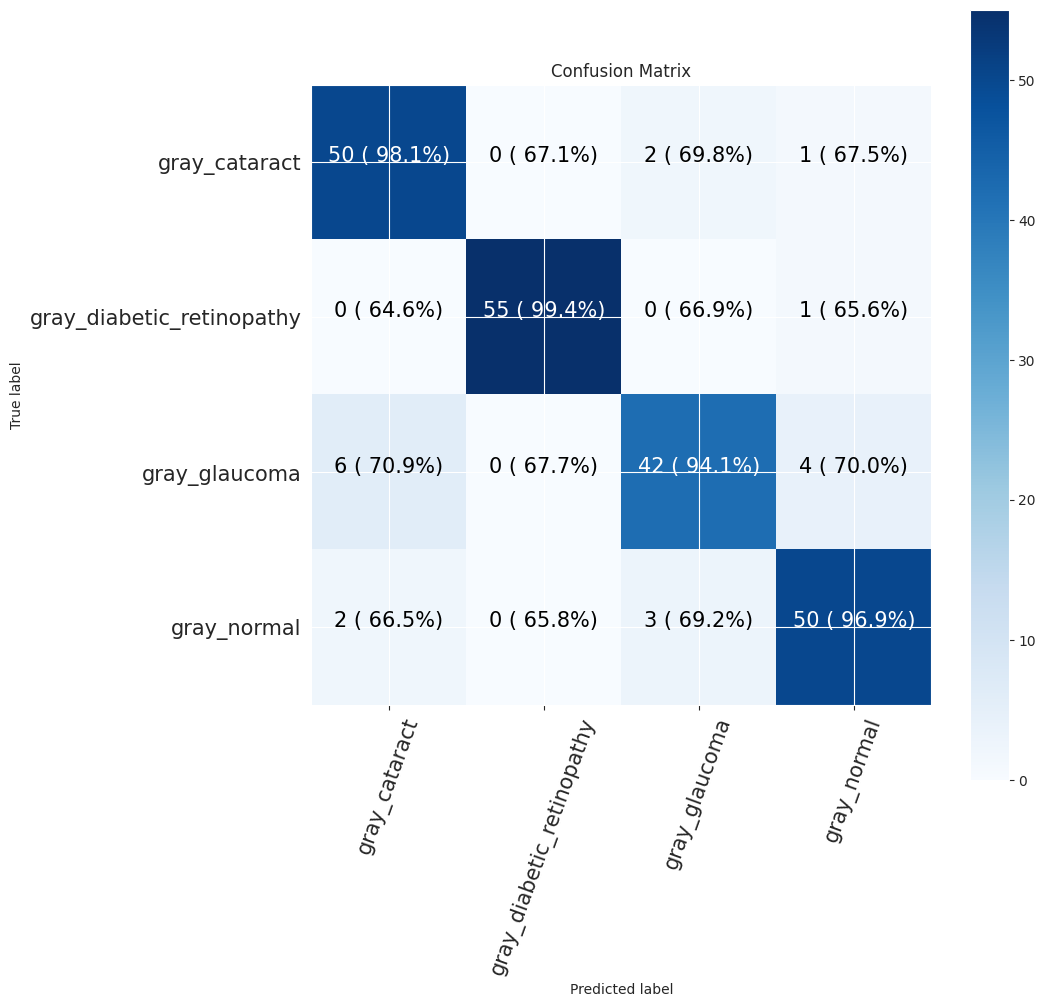

In [104]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


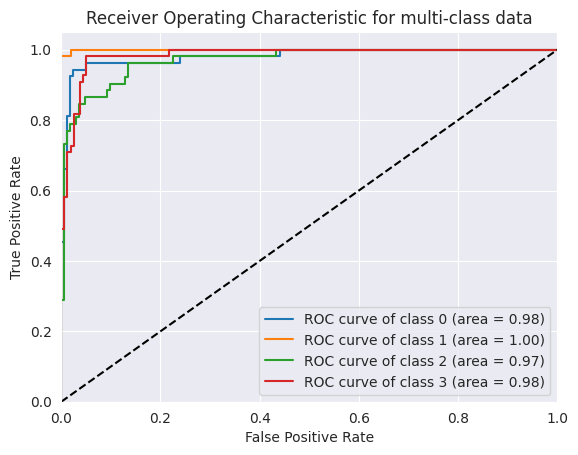

In [105]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [106]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
# grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_17 (Conv2D)          (None, 224, 224, 3)       30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_9  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_27 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_28 (Dense)            (None, 4)                 4100      
                                                           

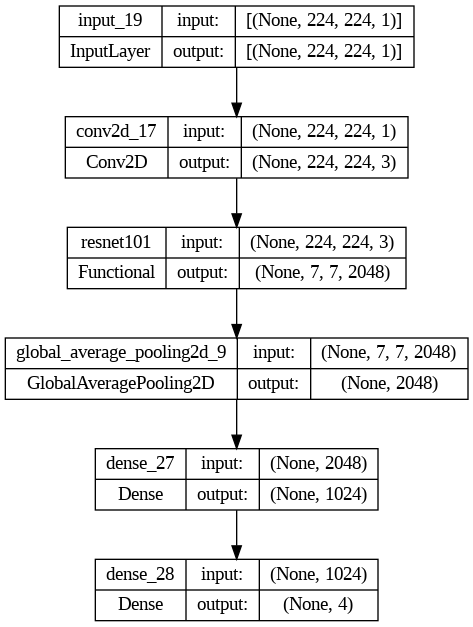

In [107]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [108]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [109]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
60/60 [==============================] - 59s 869ms/step - loss: 0.7470 - accuracy: 0.7501 - val_loss: 0.4726 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 49s 818ms/step - loss: 0.3625 - accuracy: 0.8615 - val_loss: 0.4356 - val_accuracy: 0.7943 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 50s 827ms/step - loss: 0.3415 - accuracy: 0.8725 - val_loss: 0.4534 - val_accuracy: 0.8086 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 50s 823ms/step - loss: 0.3093 - accuracy: 0.8822 - val_loss: 0.4011 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 50s 827ms/step - loss: 0.2577 - accuracy: 0.9022 - val_loss: 0.3625 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 50s 827ms/step - loss: 0.2457 - accuracy: 0.9095 - val_loss: 0.3497 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 50s 827ms/st

ResNet101 Evaluation

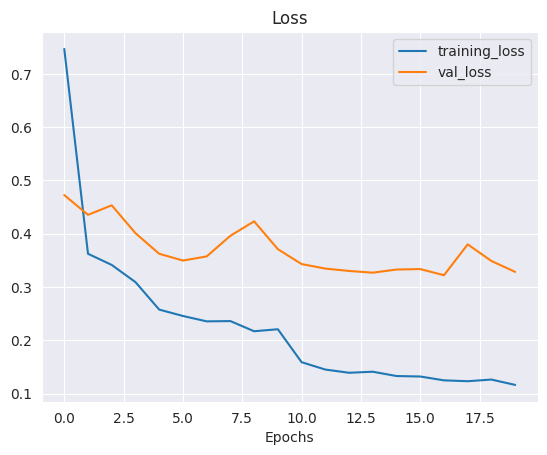

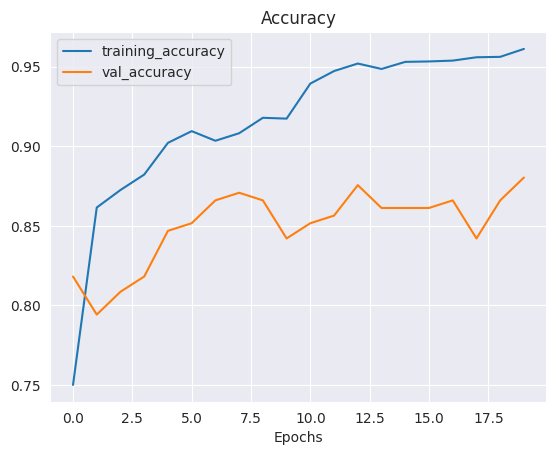

In [110]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 318ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        53
           1       0.96      0.98      0.97        56
           2       0.83      0.77      0.80        52
           3       0.85      0.82      0.83        55

    accuracy                           0.88       216
   macro avg       0.88      0.88      0.88       216
weighted avg       0.88      0.88      0.88       216

Specificity: [0.30120481927710846, 0.3416149068322981, 0.22727272727272727, 0.2631578947368421]
Mean Squared Error: : 0.11211607605218887
The average AUC-ROC is 0.979092490388191


[0.9810126582278481,
 0.6666666666666666,
 0.6964285714285714,
 0.6809815950920245,
 0.6455696202531646,
 0.9937106918238994,
 0.6666666666666666,
 0.6625766871165644,
 0.7088607594936709,
 0.6729559748427673,
 0.9285714285714286,
 0.7177914110429447,
 0.6645569620253164,
 0.6666666666666666,
 0.7083333333333334,
 0.9386503067484663]

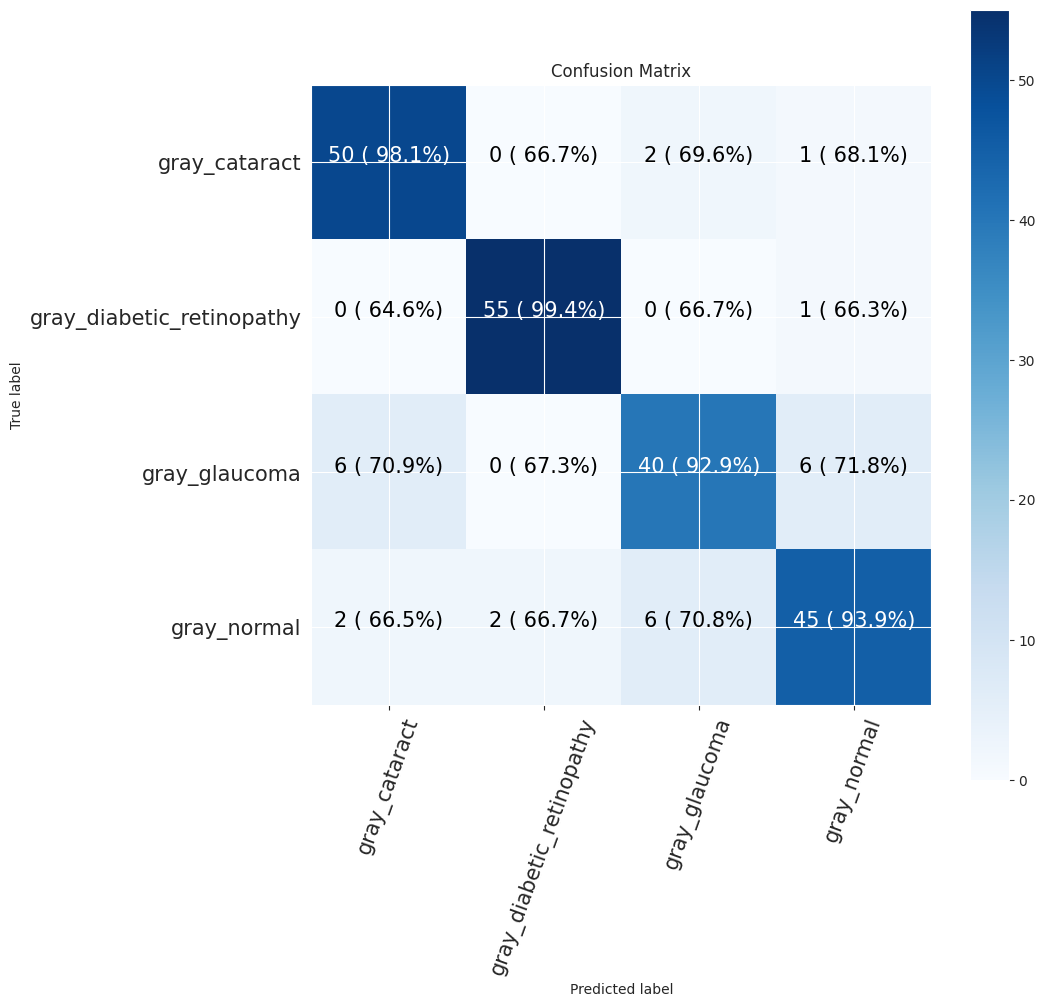

In [111]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


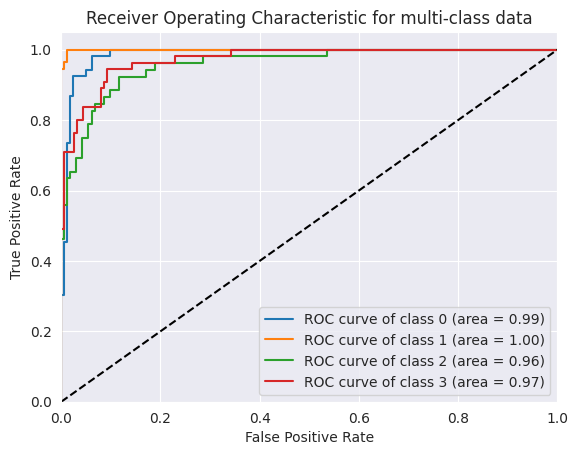

In [112]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()